In [41]:
import seaborn as sns
import os, sys
# Add the parent directory to the system path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
#export JAX_PLATFORM_NAME=cpu set env
os.environ["JAX_PLATFORM_NAME"] = "cpu"

from crazymarl.experiments.experiment_loader import Experiment
import numpy as np
sns.set_theme(style="white", palette="muted", font_scale=0.8)

import mpl_fontkit as fk
# 1. Install and register Inter
fk.install("Inter")  
fk.set_font("Inter")  

import matplotlib.pyplot as plt

# # — Use TrueType embedding (requires matplotlib≥3.10.1):
# plt.rcParams['pdf.fonttype'] = 3
# plt.rcParams['ps.fonttype']  = 3


# Set the default font size for all plots
plt.rcParams['font.size'] = 10

textwidth = 6.32283  # inches from 455,24411 pt textwidth in the document
# set default figure width to textwidth
plt.rcParams['figure.figsize'] = (textwidth, textwidth * 0.618)  # golden ratio
plt.rcParams['figure.dpi'] = 300  # high-quality output

color_array = sns.color_palette("muted", 10)

Font name: `Inter`


In [42]:
import numpy as np
from scipy.optimize import least_squares

def cable_path(p0, p1, cable_length, resolution=0.01):
    p0, p1 = np.array(p0, float), np.array(p1, float)
    straight_dist = np.linalg.norm(p1 - p0)
    # Too short? —> straight line
    if cable_length <= straight_dist or straight_dist < 1e-6:
        t = np.linspace(0, 1, int(np.ceil(straight_dist / resolution)) + 1)
        return np.outer(1 - t, p0) + np.outer(t, p1)

    # Horizontal span & direction
    delta = p1 - p0
    dh = np.linalg.norm(delta[:2])
    e_h = (delta[:2] / dh).tolist() + [0.0] if dh >= 1e-6 else [1.0, 0.0, 0.0]
    S = dh
    z0, z1 = p0[2], p1[2]

    # Residuals for [a, u]
    def eqs(vars):
        a, u = vars
        return [
            a * (np.cosh((S - u) / a) - np.cosh(u / a)) - (z1 - z0),
            a * (np.sinh((S - u) / a) + np.sinh(u / a)) - cable_length
        ]

    # Initial guess
    a0 = cable_length**2 / (8 * (cable_length - S)) if cable_length != S else S / 2
    guess = [a0, S / 2]

    # Solve with positivity bounds on a and 0≤u≤S
    bounds = ([1e-6, 0], [np.inf, S])
    sol = least_squares(eqs, guess, bounds=bounds)
    a, u = sol.x

    # Build catenary
    C = z0 - a * np.cosh(u / a)
    xs = np.linspace(0, S, int(np.ceil(S / resolution)) + 1)
    zs = a * np.cosh((xs - u) / a) + C

    # Map back to 3D
    eh = np.array(e_h)
    points = p0 + np.outer(xs, eh) + np.outer(zs - z0, [0, 0, 1])
    return points

In [43]:

class JSONExperiment:
    """
    Loads all JSON-formatted experiment logs from a directory,
    aggregates fields across runs, and sets them as attributes.

    Numeric list fields are converted to NumPy arrays and stacked
    into arrays of shape (timesteps, runs, ...).

    Example:
        exp = JSONExperiment('data/experiments')
        print(exp.num_runs)
        print(exp.payload_pos.shape)  # (timesteps, runs, 3)
    """
    def __init__(self, dir_path: str):
        import os, glob, json
        self._dir_path = dir_path
        # Discover JSON files
        file_paths = sorted(glob.glob(os.path.join(dir_path, '*.json')))
        self.num_runs = len(file_paths)
        print(f"Found {self.num_runs} runs in {dir_path}")
        self.run_paths = file_paths
        # Load each run's raw data
        raw_runs = []
        self.run_indices = []
        for fp in file_paths:
            with open(fp, 'r') as f:
                data = json.load(f)
            raw_runs.append(data)
            self.run_indices.append(data.get('run_index', None))

       

        # Determine all keys present
        all_keys = set().union(*(run.keys() for run in raw_runs))
        # Fields to convert and stack as arrays
        array_fields = ['time', 'dones', 'trajectory',
                        'payload_pos', 'payload_vel', 'payload_error',
                        'payload_linvel', 'agent_rel_pos', 'agent_rot_flat',
                        'agent_linvel', 'agent_angvel', 'agent_action',
                        'quad_pos', 'quad_vel', 'quad_rot']

        for key in all_keys:
            # Gather values per run
            vals = [run.get(key, None) for run in raw_runs]
            if key in array_fields and any(v is not None for v in vals):
                # Convert list to arrays
                arrs = []
                for v in vals:
                    try:
                        arrs.append(np.array(v))
                    except Exception:
                        arrs.append(None)
                # Stack only non-None arrays
                valid = [a for a in arrs if a is not None]
                if valid:
                    try:
                        stacked = np.stack(arrs, axis=1)
                    except Exception:
                        # Fallback: leave as list of arrays
                        stacked = arrs
                    setattr(self, key, stacked)
                else:
                    setattr(self, key, None)
            else:
                # Non-array or missing: keep list of run values
                setattr(self, key, vals)

            # Convert quad_rot quaternions to rotation matrices with shape (time, run, quad, 9)
            if 'quad_rot' in all_keys:
                # raw_runs contains one entry per run: each run['quad_rot'] has shape (timesteps, quads, 4)
                quats = np.array([run.get('quad_rot', None) for run in raw_runs])  # (runs, time, quads, 4)
            
                if quats.ndim == 4 and quats.shape[1] > 0:
                    # reorder to (time, runs, quads, 4)
                    quats = np.transpose(quats, (1, 0, 2, 3))
                    t, r, q, _ = quats.shape
                    from scipy.spatial.transform import Rotation as R
                    quats = quats.reshape(-1, 4)  # flatten to (t*r*q, 4), convert to (t*r*q, 3, 3), then reshape and flatten last two dims
                    # quats a w, x, y, z, so we need to change the order to x, y, z, w
                    quats = quats[:, [1, 2, 3, 0]]
                    rots = R.from_quat(quats).as_matrix()  # convert quatern

                    self.agent_rot_flat = rots.reshape(t, r, q, 9)
                  
            else:
                self.agent_rot_flat = None

        
        self.trajectory = None
        self.full_runs = range(self.num_runs)
        self.env_config = raw_runs[0].get('env_config', {})
        self.payload_error = self.payload_pos[:, :, :] - np.array([0.0, 0.0, 1.5])

        self.num_quads = self.env_config.get('num_quads', 1)



    def __repr__(self):
        return (
            f"<JSONExperiment dir={self._dir_path!r} "
            f"runs={self.num_runs} timesteps={getattr(self, 'time', None).shape[0] if hasattr(self, 'time') and isinstance(self.time, np.ndarray) else 'N/A'}>"
        )


Experiment loaded from ../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf with 2 quads


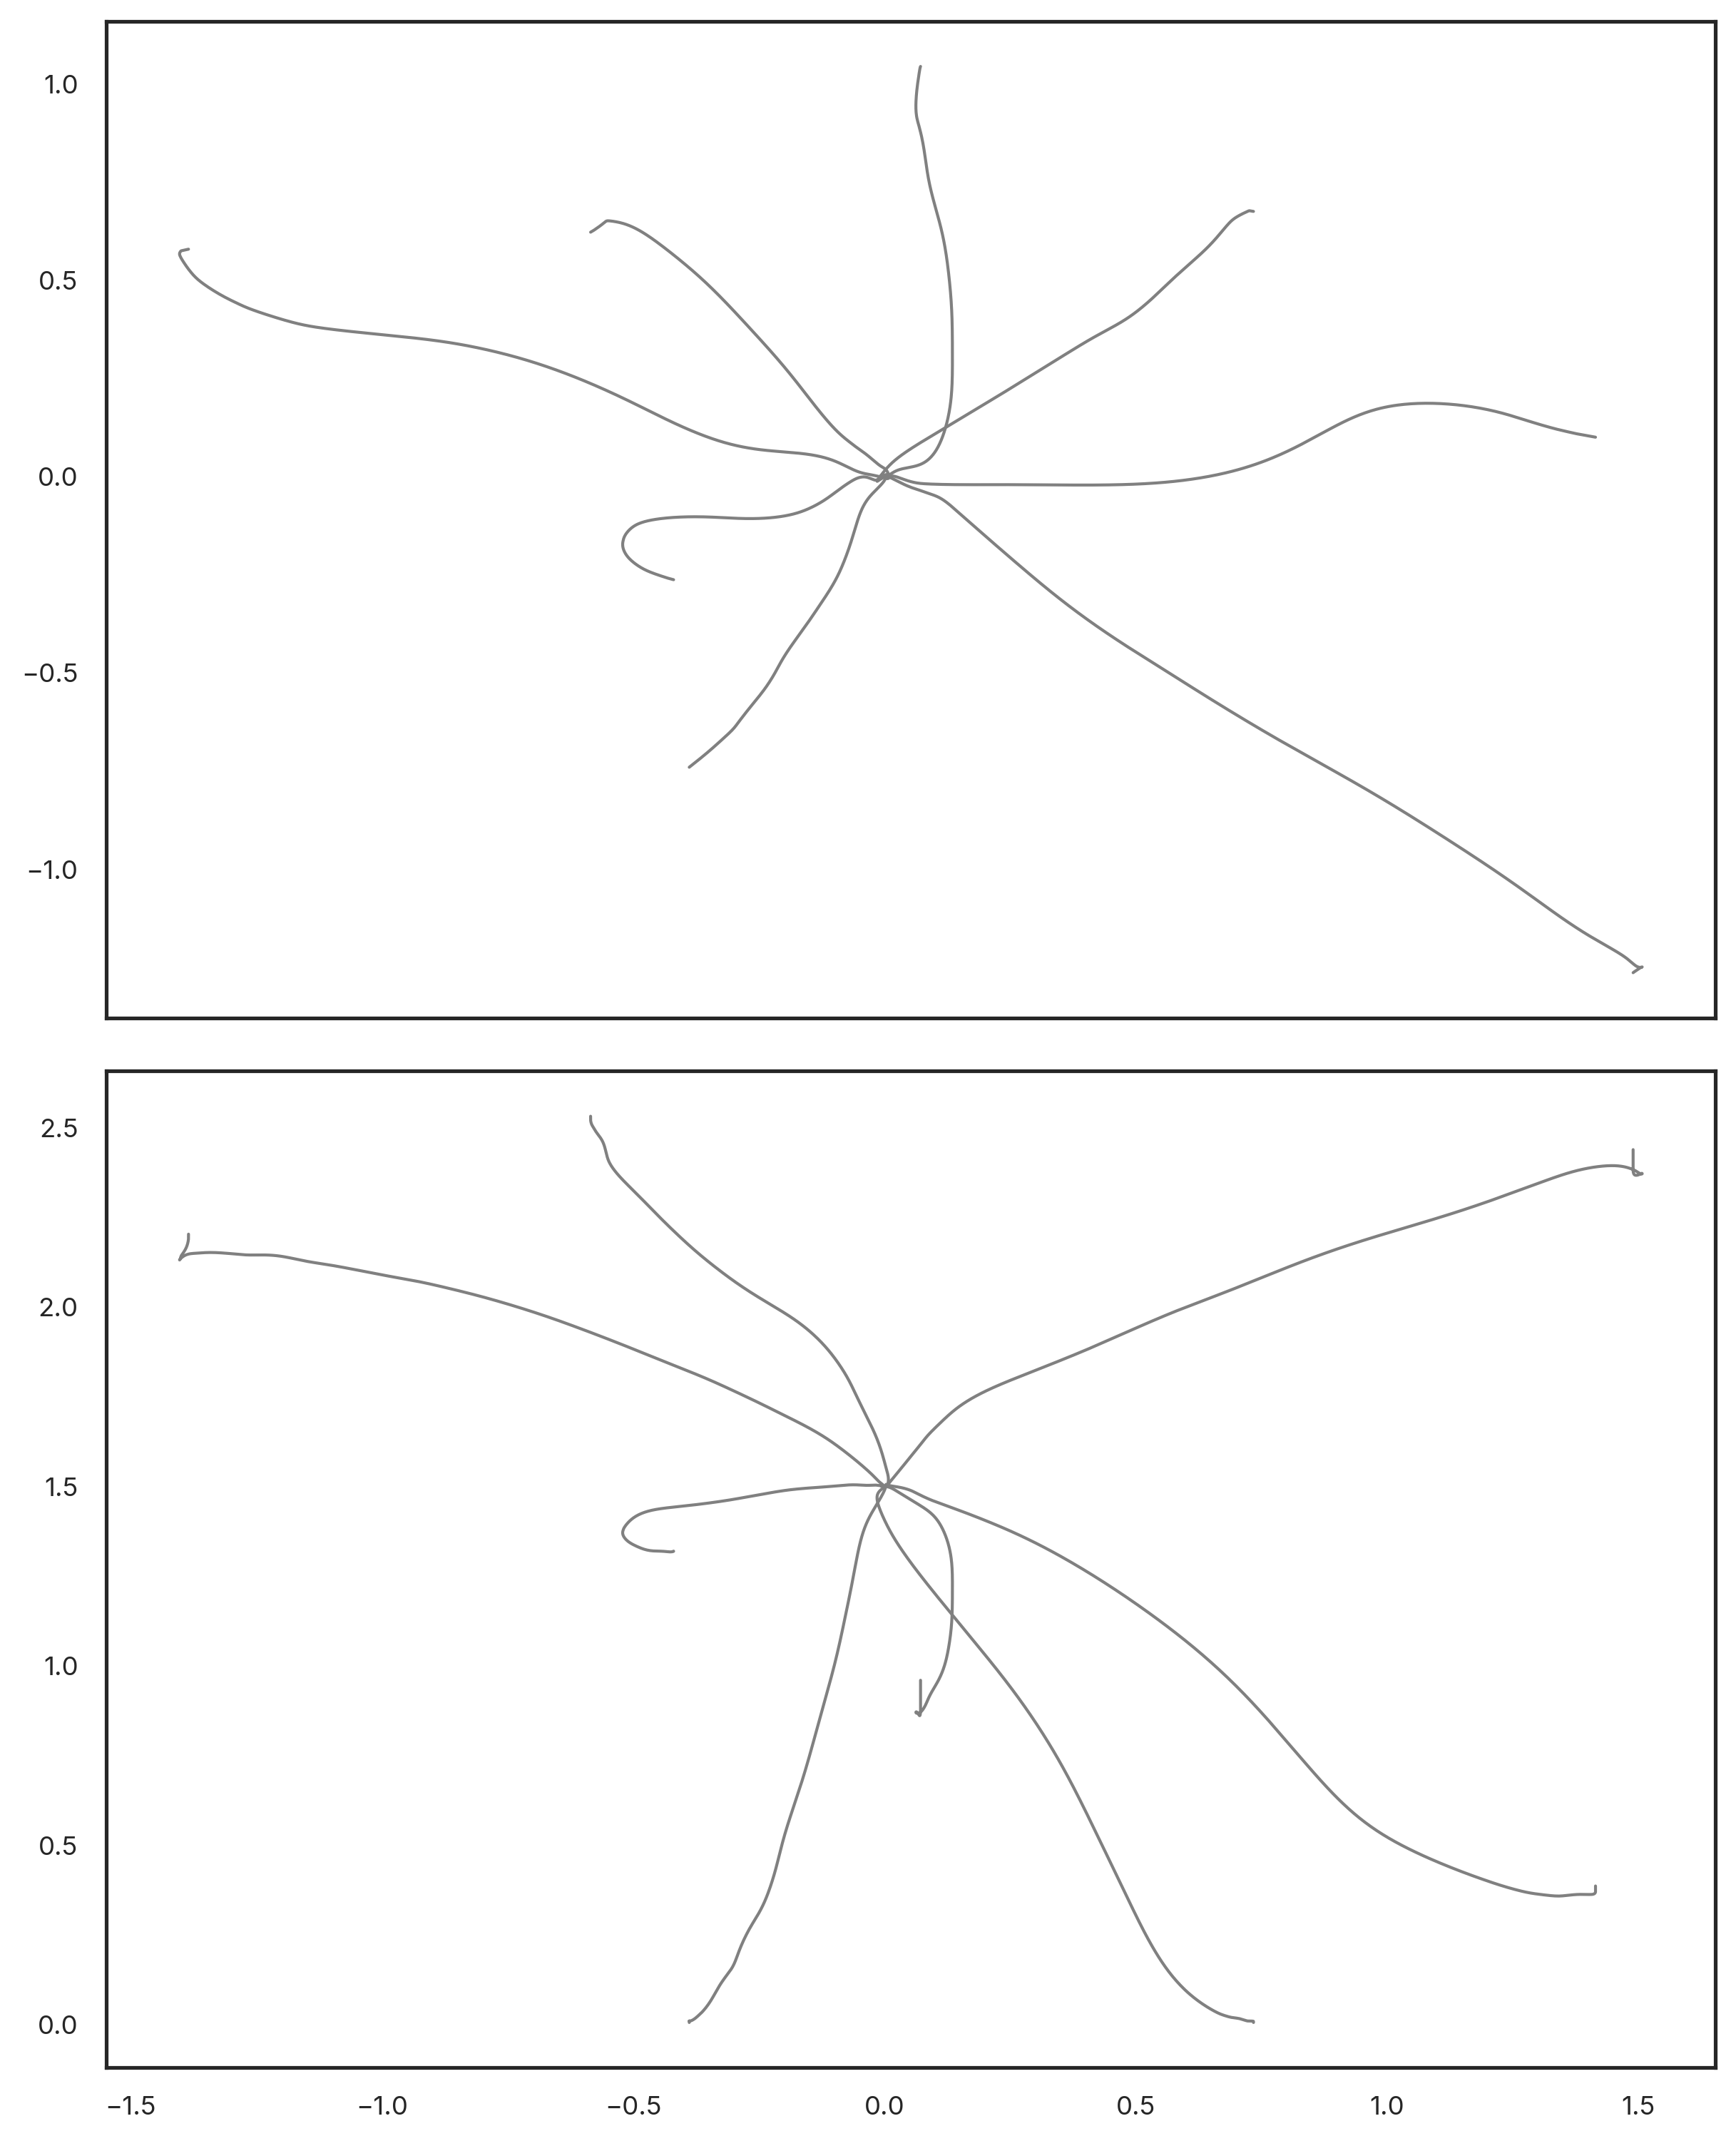

In [44]:
import numpy as np
import matplotlib.pyplot as plt


def plot_payload_gray(exp: Experiment,
                      runs=None,
                      width: float = 6.0,
                      time: slice = None,
                      xlimits: tuple = None,
                      zlimits: tuple = None,
                      fig_ax: tuple = None):
    """
    Plot only the payload position for each run as a gray line.
    Top: X–Y plane.  Bottom: X–Z plane.
    
    Args:
        exp:           Experiment object with payload_pos.
        runs:          list or array of run indices to plot.
        width:         width of new figure (ignored if fig_ax is provided).
        time:          slice object to index into time dimension.
        xlimits:       tuple (xmin, xmax) for X axis.
        zlimits:       tuple (zmin, zmax) for Z axis.
        fig_ax:        Optional existing (fig, (ax_xy, ax_zx)). If provided,
                       plotting is done on these axes.
    
    Returns:
        fig, (ax_xy, ax_zx)
    """
    # select runs
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs[runs] if runs is not None else np.array([0])
    t_idx = time if time is not None else slice(None)

    # use existing axes or create new
    if fig_ax is None:
        fig, (ax_xy, ax_zx) = plt.subplots(
            2, 1, sharex=True,
            figsize=(width, width * 0.618 * 2),
            gridspec_kw={'hspace': 0.05},
            constrained_layout=True
        )
    else:
        fig, (ax_xy, ax_zx) = fig_ax

    rels = []
    # plot each run's payload trajectory in gray
    for idx in run_idxs:
        rel = exp.payload_pos[t_idx, idx, :]  # shape (T, 3)
        rels.append(rel)
        ax_xy.plot(rel[:, 0], rel[:, 1], color='gray', lw=1)
        ax_zx.plot(rel[:, 0], rel[:, 2], color='gray', lw=1)

    # # apply limits if provided
    # if xlimits is not None:
    #     ax_xy.set_xlim(xlimits)
    # if zlimits is not None:
    #     ax_zx.set_ylim(zlimits)

    # # labels & aspect (only for new axes; safe to call again on existing)
    # ax_xy.set_ylabel('Y [m]')
    # ax_zx.set_ylabel('Z [m]')
    # ax_zx.set_xlabel('X [m]')
    # for ax in (ax_xy, ax_zx):
    #     ax.set_aspect('equal', adjustable='datalim')

    return fig, (ax_xy, ax_zx), rels


# Example usage:
two_recovery = Experiment('../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf')

# 1) Create a base figure:
fig, axes, _= plot_payload_gray(
    two_recovery,
    runs=[376, 387, 302, 382,259, 58, 290, 562],
    width=8.0,
    xlimits=(-2.6, 2.6),
    zlimits=(-0.1, 1.5)
)

Found 1000 runs in /Users/viktorlorentz/Dev/ma/crazyflie-sim/data/output


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


[308 320 227 315 178 534 213 515]
Run 0 (308): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 1 (320): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 2 (227): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 3 (315): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 4 (178): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 5 (534): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 6 (213): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)
Run 7 (515): 2500 timesteps, payload shape (2500, 3), velocity shape (2500, 1000, 3)


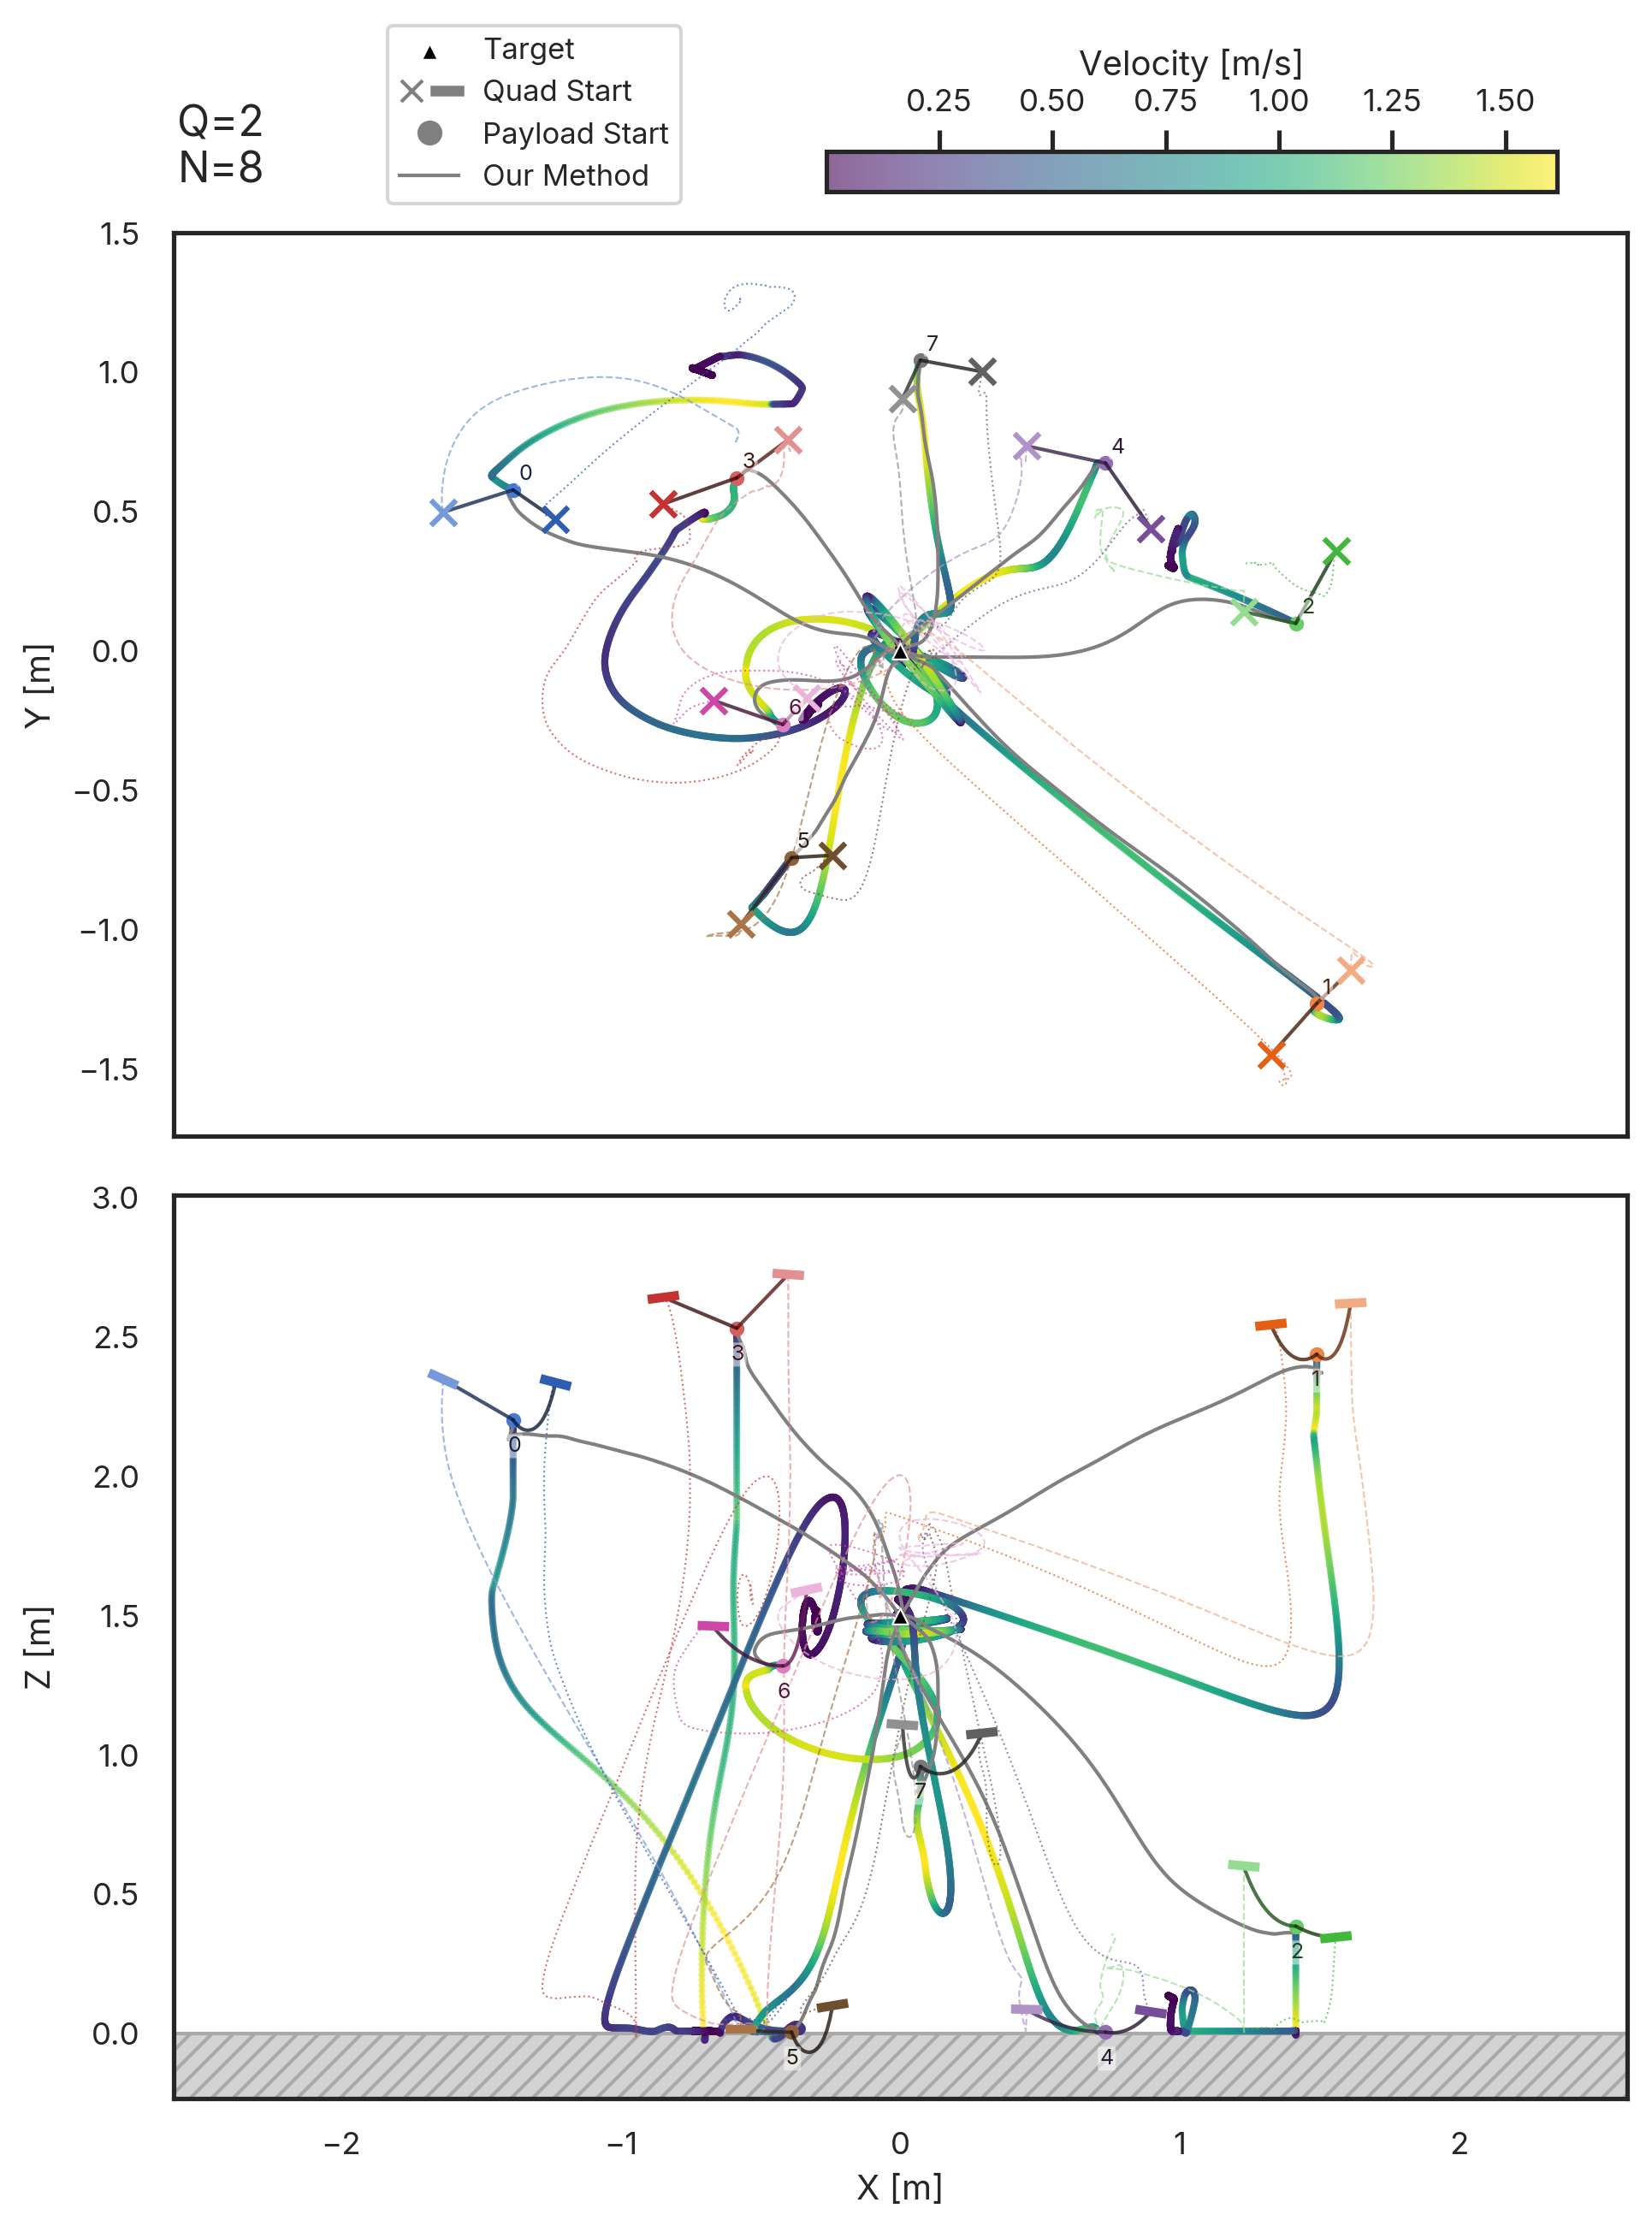

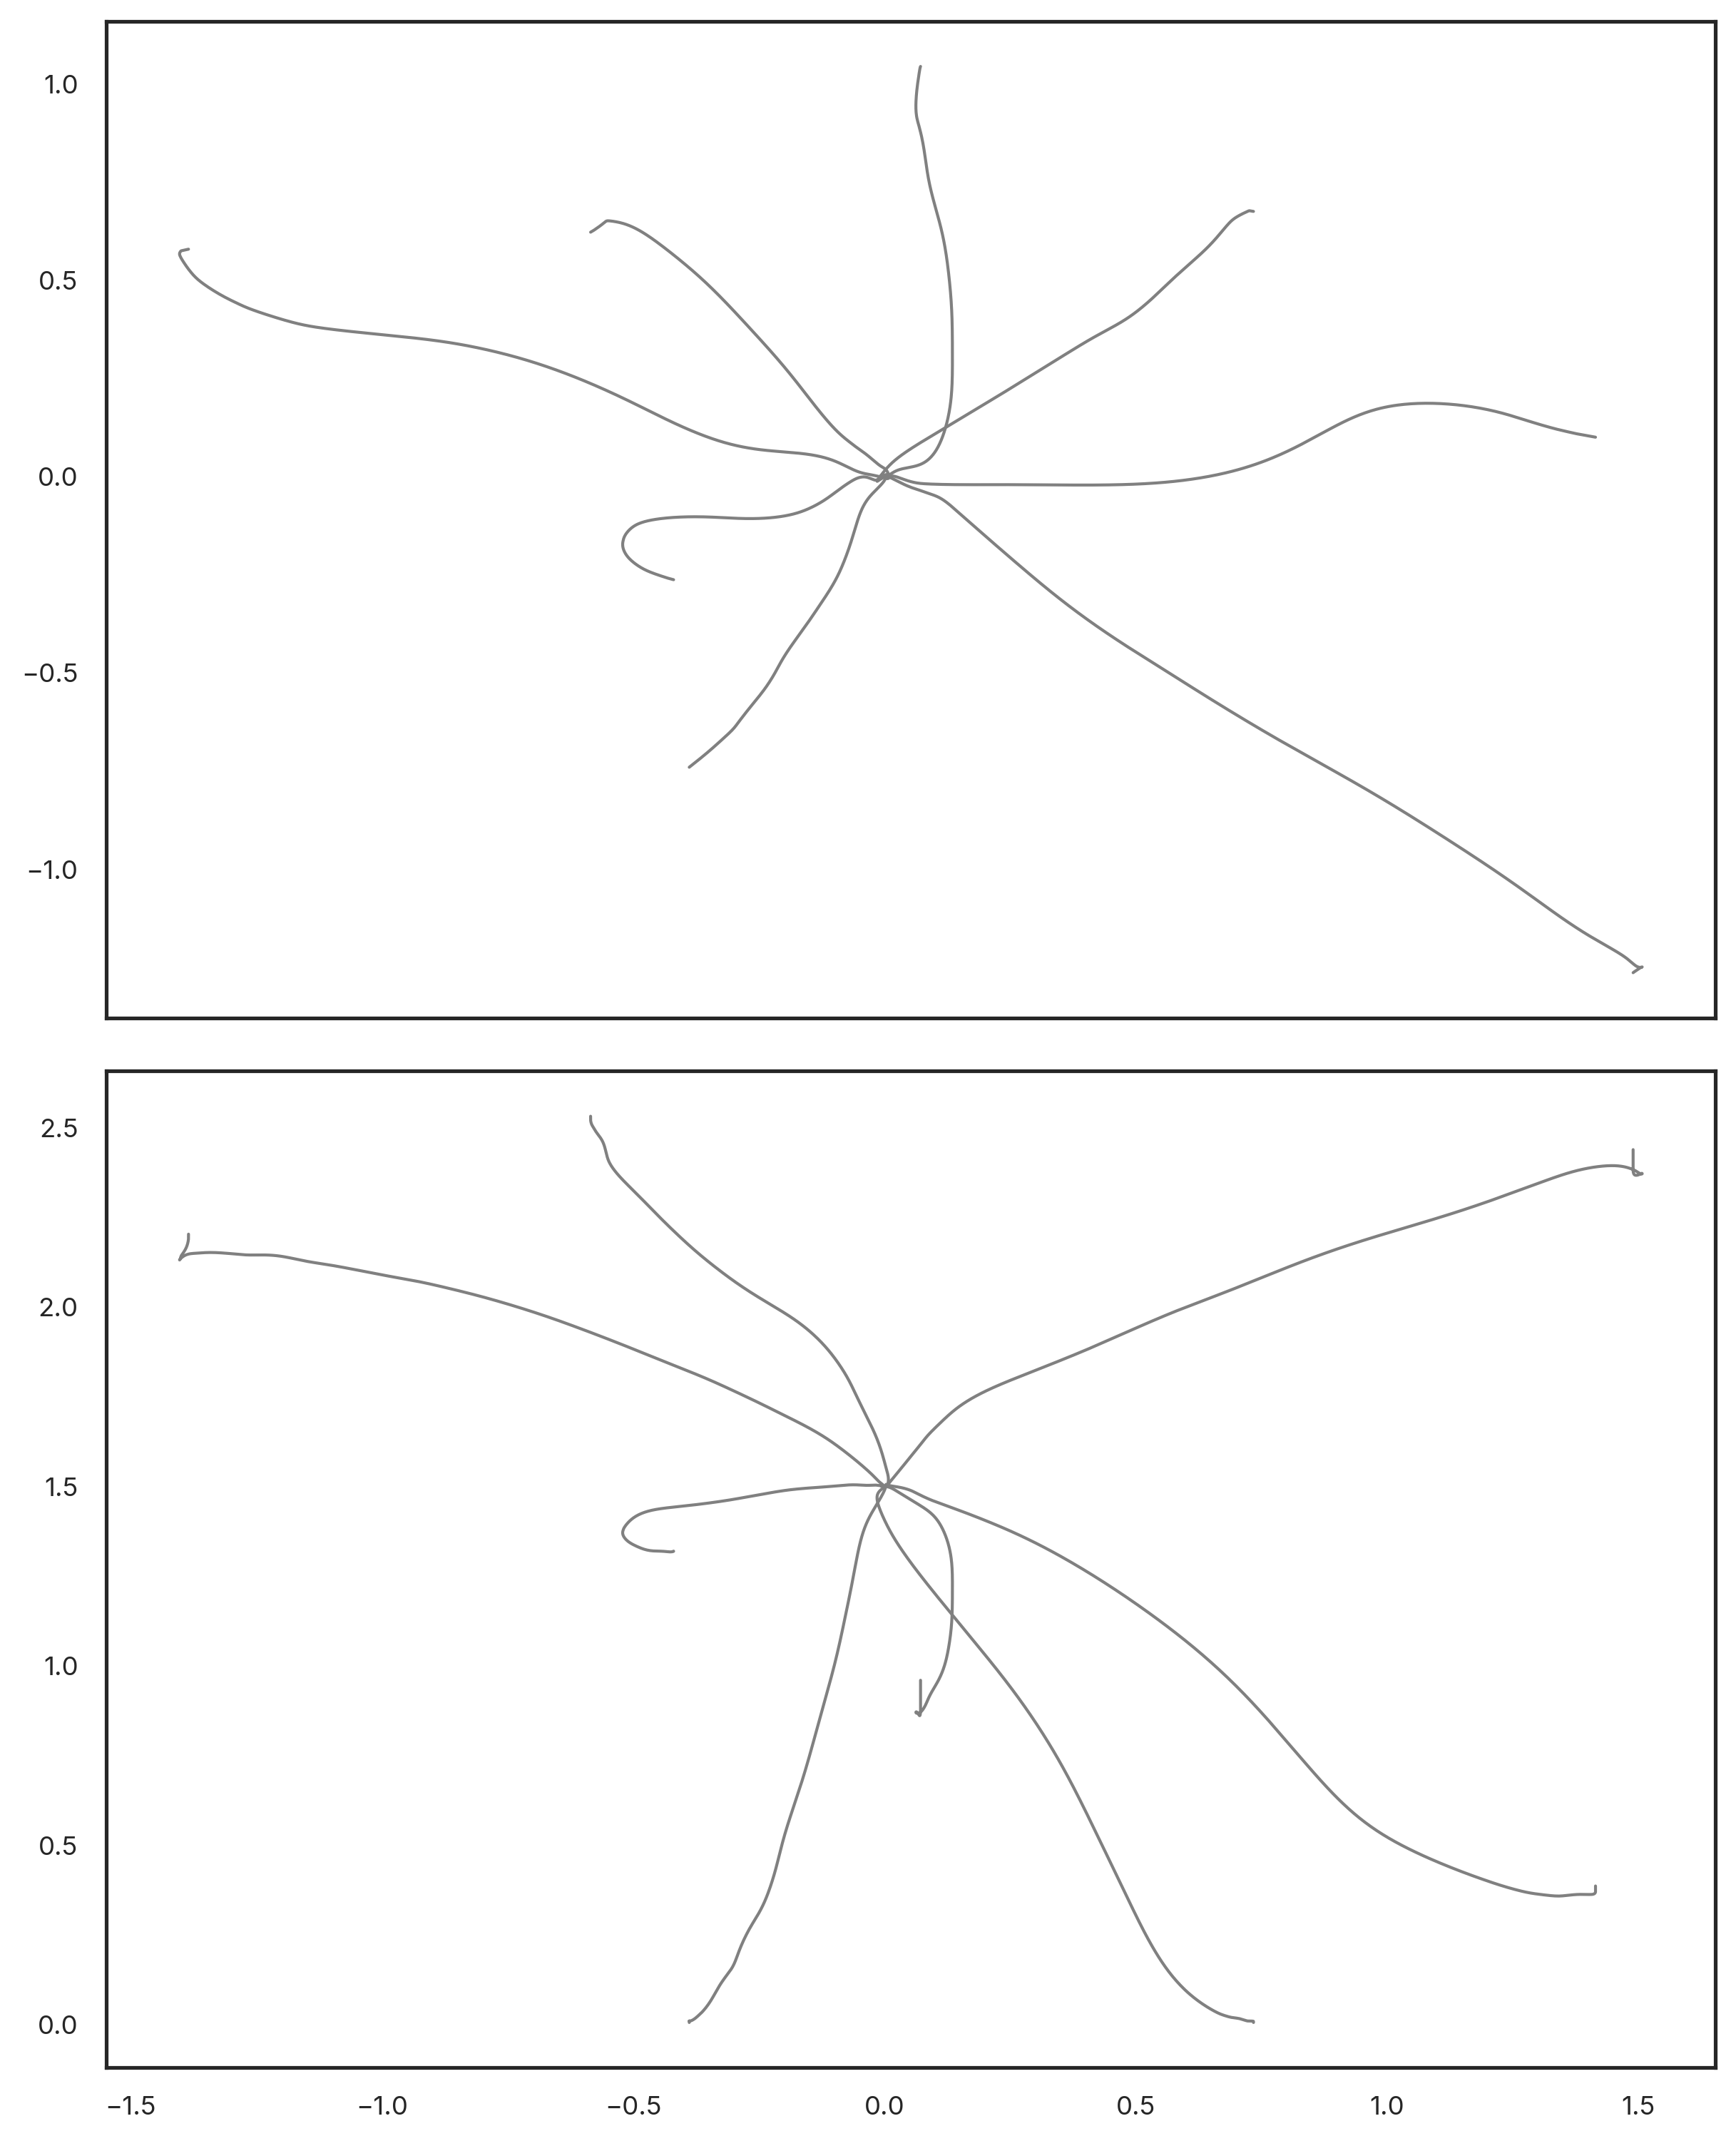

In [45]:

import colorsys
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D


def _adjust_lightness(rgb, factor):
    """Lighten (factor>1) or darken (factor<1) an RGB tuple."""
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

def plot_xy_zx_plane(exp,
                     runs=None,
                     width: float = textwidth,
                     show_quads: bool = True,
                     time: slice = None,
                     xlimits: tuple = None,
                     zlimits: tuple = None,
                     color_info: str = "time",  # 'time' or 'velocity'
                     show_run_id: bool = False,
                     reduce_quad_id: bool = True,  # reduce run ID to 0,1,2,3,...
                     show_failed: bool = False  # show runs that failed to complete
                     ):
    """
    - Top: XY plane.  Bottom: ZX plane.
    - Share X axis, slim colorbar, single legend.
    - Equal-width boxes via adjustable='datalim'.
    - Manual X/Z limits allowed; Y auto for equal aspect.
    - Rotated quad rectangles in ZX from exp.agent_rot_flat.
    - Ground rectangle for z<0 in ZX.
    - Color of payload trajectory represents time or velocity norm.
    - Annotate each payload start with its run ID (reduced or original).
    - Legend entry for Quad Start shows both 'x' marker and filled rectangle.
    - Uses exp.quad_pos (absolute quad positions) instead of computing from rel+payload.
    """
    # choose runs
   # all_runs = np.arange(exp.num_runs)
    #run_idxs = all_runs[runs] if runs is not None else all_runs
    run_indexes = np.array(exp.run_indices)
    #find index of runs in run_indexes
    if runs is None:
        runs = run_indexes
    else:
        # build a lookup from value → its first index
        idx_map = { val: idx for idx, val in enumerate(run_indexes) }

        # for each run number, pull out the index (or -1 if missing)
        mapped_ids = np.array([ idx_map.get(r, -1) for r in runs ])

        print(mapped_ids)
    completed = mapped_ids
    # if  not show_failed:
    #     completed = np.intersect1d(exp.full_runs, run_idxs)

    # time slice
    t_idx = time if time is not None else slice(None)
    rots_flat = exp.agent_rot_flat  # shape (T, runs, quads, 9)
    cable_length = exp.env_config['cable_length']
    quad_w, quad_h = 0.10, 0.02
    base_colors = sns.color_palette("muted", n_colors=len(completed))

    velocity = exp.payload_linvel  # shape (T, runs, 3)

    #setup figure
    fig, (ax_xy, ax_zx) = plt.subplots(
        2, 1, sharex=True,
        figsize=(width, width * 0.618 * 2),
        gridspec_kw={'hspace': 0.05},
        constrained_layout=True
    )
    _ , _ , rels = plot_payload_gray(
        two_recovery,
        runs=runs,
        width=8.0,
        xlimits=(-2.6, 2.6),
        zlimits=(-0.1, 1.5)
    )
    for rel in rels:
        ax_xy.plot(rel[:, 0], rel[:, 1], color='gray', lw=1)
        ax_zx.plot(rel[:, 0], rel[:, 2], color='gray', lw=1)

    all_x = []
    planes = [(ax_xy, 1), (ax_zx, 2)]

    cmap_name = 'crest' if color_info == 'time' else 'viridis'

    # background trajectory
    traj = exp.trajectory
    if traj is not None and traj.shape and traj.shape[1] == 3:
        tt = traj[t_idx, :]
        all_x.extend(tt[:, 0])
        for ax, zi in planes:
            ax.plot(tt[:, 0], tt[:, zi], color='gray', alpha=0.5, lw=1, label='Reference Trajectory')

    # per-run plotting
    for run_i, idx in enumerate(completed):
        disp_id = run_i if reduce_quad_id else idx
        base = base_colors[run_i]
        rel = exp.payload_pos[t_idx, idx, :]
        times = exp.time[t_idx]
        all_x.extend(rel[:, 0])

        print(f"Run {disp_id} ({idx}): {len(times)} timesteps, payload shape {rel.shape}, velocity shape {velocity.shape}")

        # color values
        if color_info == 'time':
            cvals = times
            c_label = 'Time [s]'
        else:
            # support both 4D (T, runs, quads, 3) and 3D (T, runs, 3) velocity arrays
            if velocity.ndim == 4:
                vels = velocity[t_idx, idx, 0, :]
            else:
                vels = velocity[t_idx, idx, :]
            cvals = np.linalg.norm(vels, axis=1)
            c_label = 'Velocity [m/s]'

        # payload scatter
        for ax, zi in planes:
            sc = ax.scatter(rel[:, 0], rel[:, zi], c=cvals, cmap=cmap_name, s=1, alpha=0.6)

        # payload start
        start = rel[0]
        ax_xy.scatter(start[0], start[1], s=10, marker='o', color=base, zorder=5)
        ax_zx.scatter(start[0], start[2], s=10, marker='o', color=base, zorder=5)

        if show_run_id:
            text_color = _adjust_lightness(base, 0.3)
            ax_xy.text(start[0]+0.02, start[1]+0.02, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))
            ax_zx.text(start[0]-0.02, start[2]-0.13, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))

        # quads & cables using exp.quad_pos
        if show_quads:
            for q in range(exp.num_quads):
                quad = exp.quad_pos[t_idx, idx, q, :]  # absolute positions
                xs = quad[:, 0]
                all_x.extend(xs)

                # color & linestyle per quad
                if q == 0:
                    color = _adjust_lightness(base, 1.2); ls = '--'
                elif q == 1:
                    color = _adjust_lightness(base, 0.8); ls = ':'
                else:
                    color = base; ls = '-.'

                # quad trajectories
                for ax, zi in planes:
                    ys = quad[:, zi]
                    ax.plot(xs, ys, linestyle=ls, lw=0.5, alpha=0.7, color=color)

                # quad start marker
                ax_xy.scatter(xs[0], quad[0, 1], marker='x', s=50, color=color, zorder=6)

                # cable at start
                p_pay, p_quad = start, quad[0]
                cable_pts = cable_path(p_pay, p_quad, cable_length)
                cable_color = _adjust_lightness(color, 0.3)
                ax_xy.plot(cable_pts[:, 0], cable_pts[:, 1], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)
                ax_zx.plot(cable_pts[:, 0], cable_pts[:, 2], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)

                # rotated quad rectangle
               
                x0, z0 = p_quad[0] - quad_w/2, p_quad[2] - quad_h/2
                rect = Rectangle((x0, z0), quad_w, quad_h,
                                 edgecolor=color, facecolor=color, lw=1, zorder=6)
                if rots_flat is not None:
                    R =rots_flat[0, idx, q, :].reshape( 3,3)
                    wvec = R[:, 0] * quad_w
                    angle = np.degrees(np.arctan2(wvec[2], wvec[0]))
                    t_mat = Affine2D().rotate_deg_around(p_quad[0], p_quad[2], angle) + ax_zx.transData
                    rect.set_transform(t_mat)
                ax_zx.add_patch(rect)

    # hide top X labels
    plt.setp(ax_xy.get_xticklabels(), visible=False)

    

    # apply limits
    if xlimits is not None:
        ax_xy.set_xlim(xlimits)
    else:
        xmin, xmax = min(all_x), max(all_x)
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
        ax_xy.set_xlim(xmin - pad, xmax + pad)
    if zlimits is not None:
        ax_zx.set_ylim(zlimits)

    # ground rectangle
    x0, x1 = ax_xy.get_xlim()
    gz0, gz1 = ax_zx.get_ylim()[0], min(0, ax_zx.get_ylim()[1])
    if gz0 < 0:
        ground = Rectangle((x0, -0.5), x1 - x0, 0.5, facecolor='lightgray', edgecolor='darkgray', linewidth=1, hatch='////', zorder=-1)
        ax_zx.add_patch(ground)

    # make sure y min is at least -0.1
    y_min = ax_zx.get_ylim()[0]
    if y_min < -0.1:
        ax_zx.set_ylim(-0.1, ax_zx.get_ylim()[1])

   

    # target position
    if traj is None or not traj.shape or traj.shape[1] != 3:
        target = np.array([0.0, 0.0, 1.5])
        ax_xy.scatter(target[0], target[1], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)
        ax_zx.scatter(target[0], target[2], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)

    fig.text(0.1, 1.01, f'Q={exp.num_quads}\nN={len(completed)}', fontsize=12, ha='left', va='bottom')

    # equal aspect & align
    for ax in (ax_xy, ax_zx):
        ax.set_aspect('equal', adjustable='datalim')
    fig.align_ylabels((ax_xy, ax_zx))

    # axis labels
    ax_xy.set_ylabel('Y [m]')
    ax_zx.set_ylabel('Z [m]')
    ax_zx.set_xlabel('X [m]')

    # colorbar
    cbar_ax = fig.add_axes([0.5, 1.01, 0.45, 0.02])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', fraction=0.01, pad=0.01)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.tick_top()
    cbar.set_label(c_label)

    # legend assembly
    handles, labels = [], []
    for ax in (ax_xy, ax_zx):
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li and li not in labels:
                handles.append(hi)
                labels.append(li)
        if ax.legend_:
            ax.legend_.remove()

    # custom combined handle: quad start as cross + thick line
    quad_marker = Line2D([], [], marker='x', linestyle='None', color='gray')
    legend_line = Line2D([], [], linestyle='-', linewidth=3, color='gray', solid_capstyle='projecting')
    payload_marker = Line2D([], [], marker='o', linestyle='None', color='gray')
    ours_legend = Line2D([], [], linestyle='-', linewidth=1, color='gray', solid_capstyle='projecting')
    
    handles.append((quad_marker, legend_line))
    labels.append('Quad Start')
    handles.append(payload_marker)
    labels.append('Payload Start')
    handles.append(ours_legend)
    labels.append('Our Method')

    fig.legend(handles, labels,
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='upper center', ncol=1, fontsize='small', bbox_to_anchor=(0.32, 1.1))

    return fig


baseline_recovery = JSONExperiment('/Users/viktorlorentz/Dev/ma/crazyflie-sim/data/output')

#slice(320,342) 
#slice(329,352) [376, 387, 302, 382, 394, 352,390,34][376, 387, 302, 382,259, 58, 290, 562]
baseline_rec = plot_xy_zx_plane(baseline_recovery, runs=[376, 387, 302, 382,259, 58, 290, 562], show_quads=True, xlimits=(-2.6, 2.6),  color_info='velocity', show_run_id=True);

#save figure
baseline_rec.savefig('out/baseline_recovery.pdf', bbox_inches='tight')

Experiment loaded from ../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf with 2 quads


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


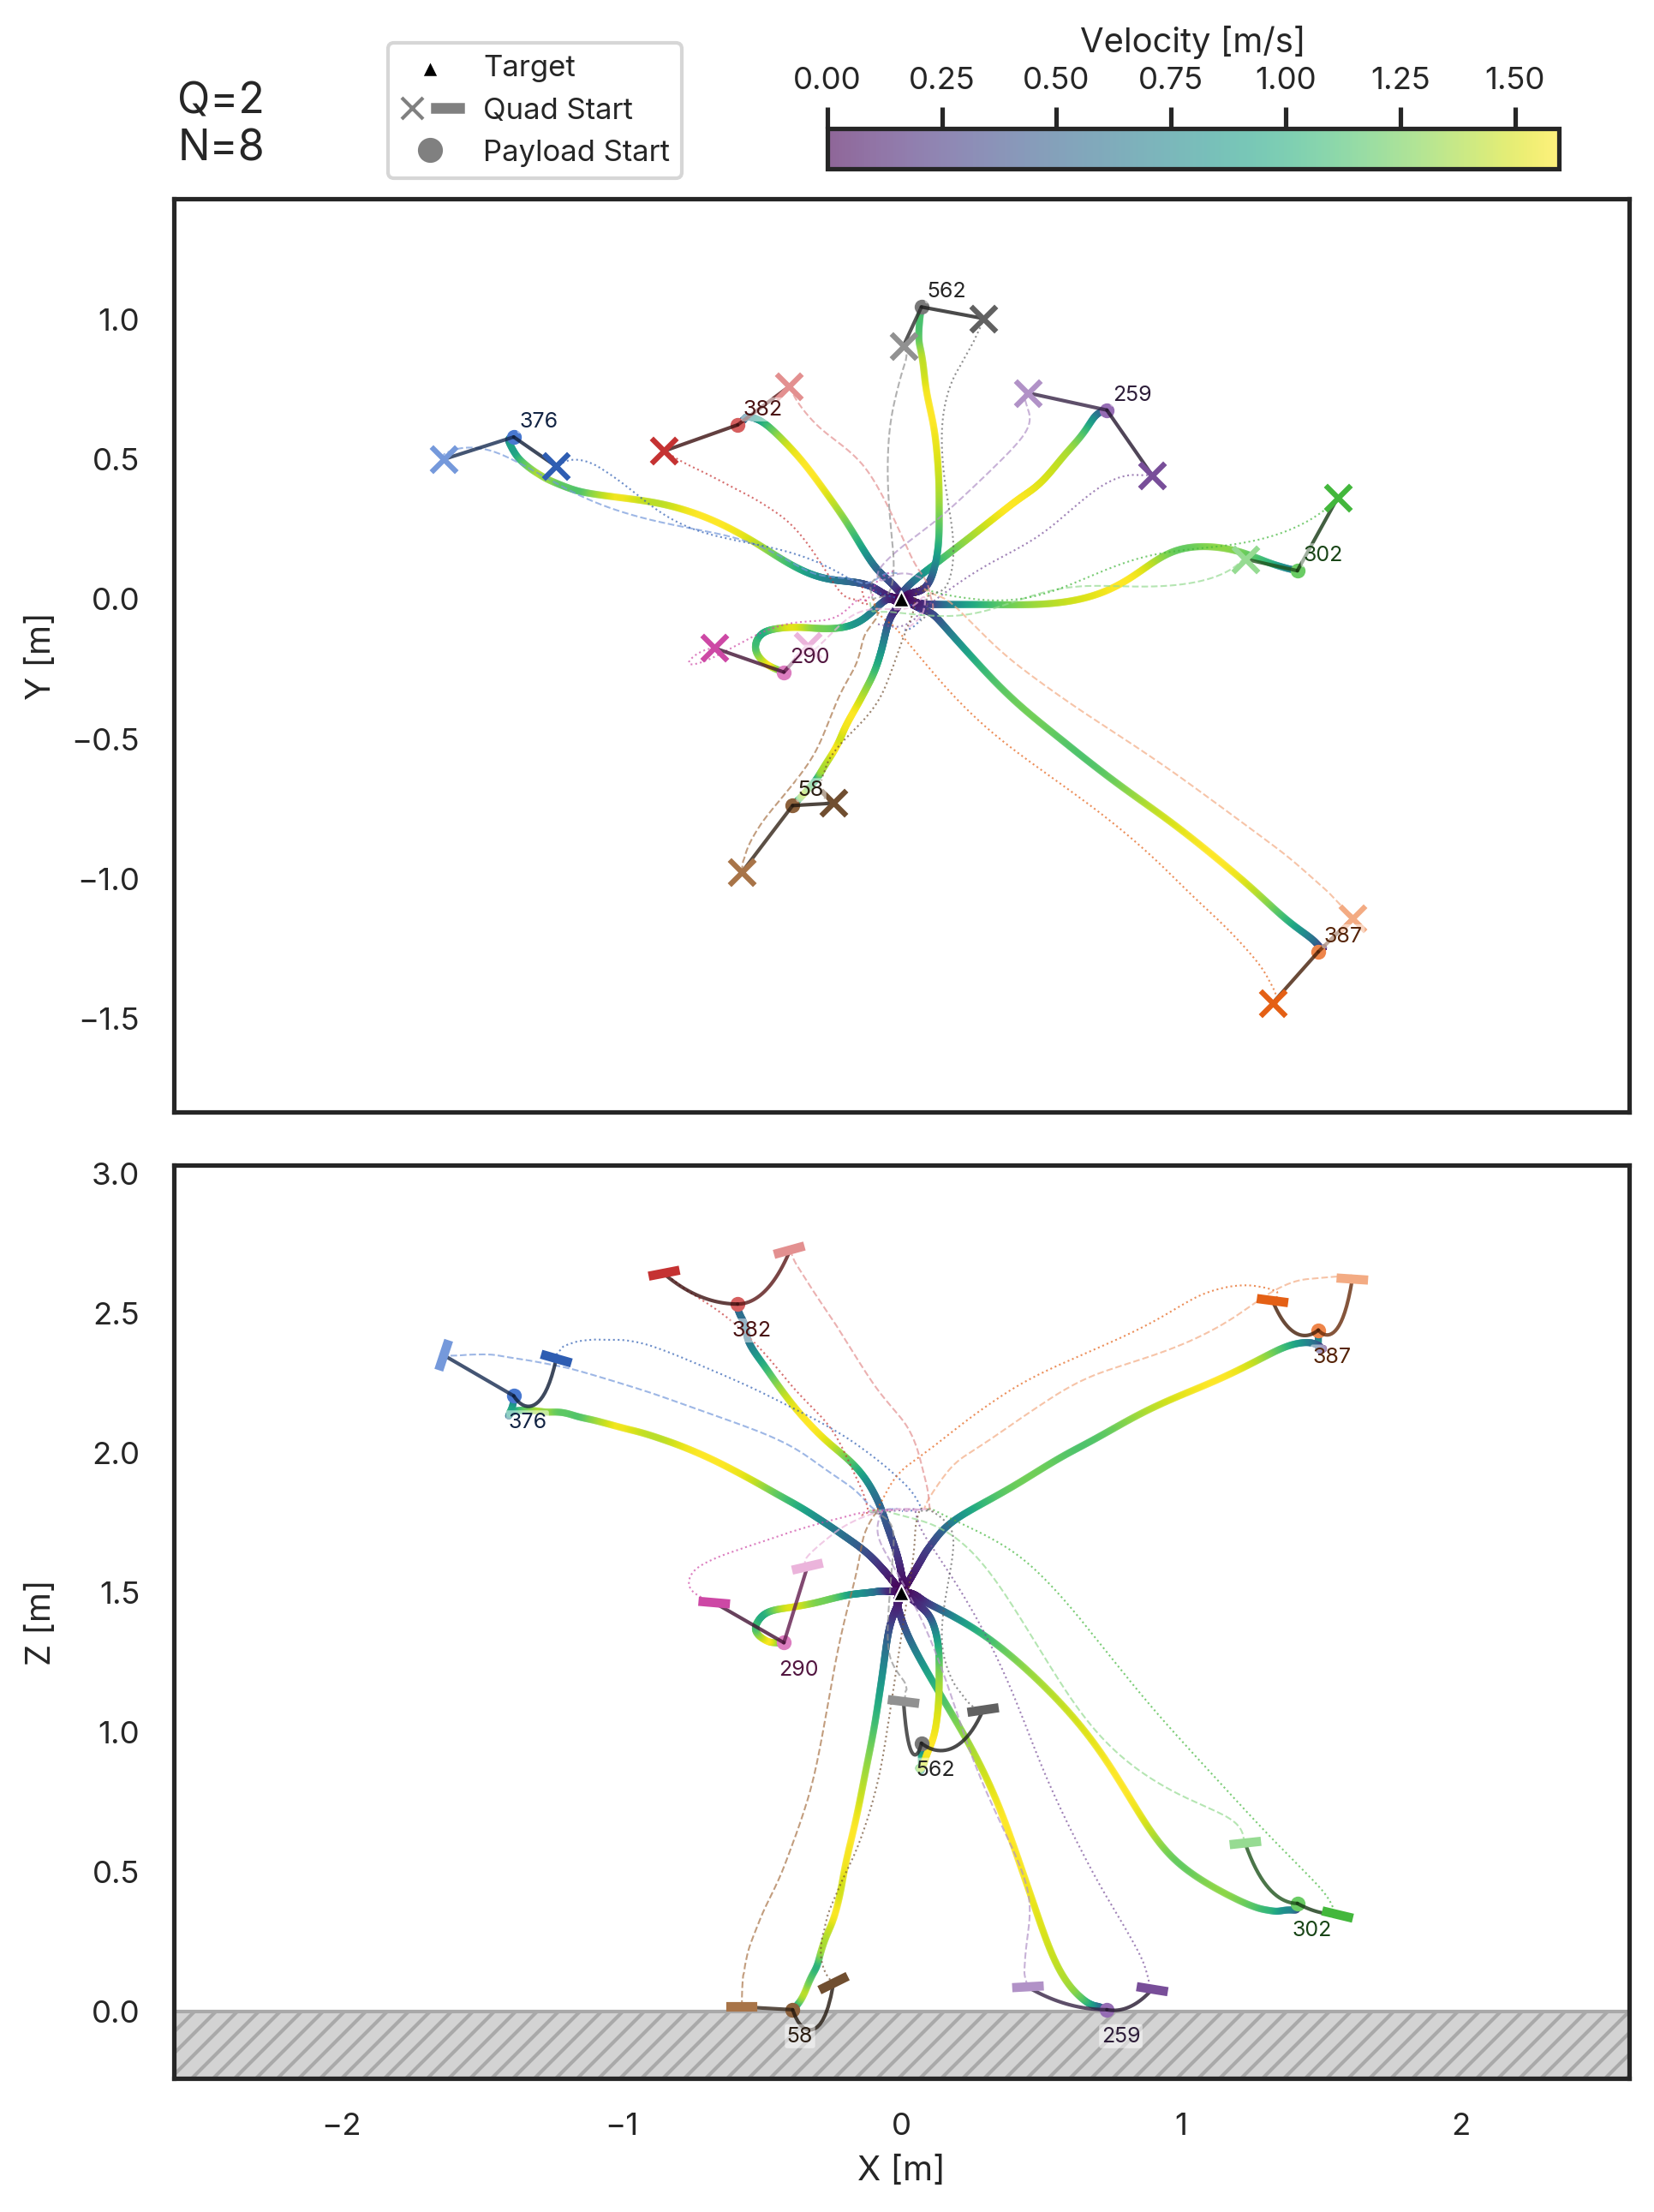

In [46]:

import colorsys
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
import jax
jax.config.update("jax_platform_name", "cpu")


import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
from crazymarl.experiments.experiment_loader import Experiment


def _adjust_lightness(rgb, factor):
    """Lighten (factor>1) or darken (factor<1) an RGB tuple."""
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * factor))
    return colorsys.hls_to_rgb(h, l, s)

def plot_xy_zx_plane(exp: Experiment,
                     runs=None,
                     width: float = textwidth,
                     show_quads: bool = True,
                     time: slice = None,
                     xlimits: tuple = None,
                     zlimits: tuple = None,
                     color_info: str = "time",  # 'time' or 'velocity'
                     show_run_id: bool = False,
                     reduce_quad_id: bool = True,  # reduce run ID to 0,1,2,3,...
                     show_failed: bool = False  # show runs that failed to complete
                     ):
    """
    - Top: XY plane.  Bottom: ZX plane.
    - Share X axis, slim colorbar, single legend.
    - Equal-width boxes via adjustable='datalim'.
    - Manual X/Z limits allowed; Y auto for equal aspect.
    - Rotated quad rectangles in ZX from exp.agent_rot_flat.
    - Ground rectangle for z<0 in ZX.
    - Color of payload trajectory represents time or velocity norm.
    - Annotate each payload start with its run ID (reduced or original).
    - Legend entry for Quad Start shows both 'x' marker and filled rectangle.
    - Uses exp.quad_pos (absolute quad positions) instead of computing from rel+payload.
    """
    # choose runs
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs[runs] if runs is not None else np.array([0])
    completed = run_idxs
    if  not show_failed:
        completed = np.intersect1d(exp.full_runs, run_idxs)

    # time slice
    t_idx = time if time is not None else slice(None)
    rots_flat = exp.agent_rot_flat  # shape (T, runs, quads, 9)
    cable_length = exp.env_config['cable_length']
    quad_w, quad_h = 0.10, 0.02
    base_colors = sns.color_palette("muted", n_colors=len(completed))

    velocity = exp.payload_linvel  # shape (T, runs, 3)

    # setup figure
    fig, (ax_xy, ax_zx) = plt.subplots(
        2, 1, sharex=True,
        figsize=(width, width * 0.618 * 2),
        gridspec_kw={'hspace': 0.05},
        constrained_layout=True
    )

    all_x = []
    planes = [(ax_xy, 1), (ax_zx, 2)]

    cmap_name = 'crest' if color_info == 'time' else 'viridis'

    # background trajectory
    traj = exp.trajectory
    if traj is not None and traj.shape and traj.shape[1] == 3:
        tt = traj[t_idx, :]
        all_x.extend(tt[:, 0])
        for ax, zi in planes:
            ax.plot(tt[:, 0], tt[:, zi], color='gray', alpha=0.5, lw=1, label='Reference Trajectory')

    # per-run plotting
    for run_i, idx in enumerate(completed):
        disp_id = run_i if reduce_quad_id else idx
        base = base_colors[run_i]
        rel = exp.payload_pos[t_idx, idx, :]
        times = exp.time[t_idx]
        all_x.extend(rel[:, 0])

        # color values
        if color_info == 'time':
            cvals = times
            c_label = 'Time [s]'
        else:
            vels = velocity[t_idx, idx, 0, :]
            cvals = np.linalg.norm(vels, axis=1)
            c_label = 'Velocity [m/s]'

        # payload scatter
        for ax, zi in planes:
            sc = ax.scatter(rel[:, 0], rel[:, zi], c=cvals, cmap=cmap_name, s=1, alpha=0.6)

        # payload start
        start = rel[0]
        ax_xy.scatter(start[0], start[1], s=10, marker='o', color=base, zorder=5)
        ax_zx.scatter(start[0], start[2], s=10, marker='o', color=base, zorder=5)

        if show_run_id:
            text_color = _adjust_lightness(base, 0.3)
            ax_xy.text(start[0]+0.02, start[1]+0.02, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))
            ax_zx.text(start[0]-0.02, start[2]-0.13, str(disp_id), fontsize=6,
                       color=text_color, ha='left', va='bottom', zorder=10,
                       bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.1'))

        # quads & cables using exp.quad_pos
        if show_quads:
            for q in range(exp.num_quads):
                quad = exp.quad_pos[t_idx, idx, q, :]  # absolute positions
                xs = quad[:, 0]
                all_x.extend(xs)

                # color & linestyle per quad
                if q == 0:
                    color = _adjust_lightness(base, 1.2); ls = '--'
                elif q == 1:
                    color = _adjust_lightness(base, 0.8); ls = ':'
                else:
                    color = base; ls = '-.'

                # quad trajectories
                for ax, zi in planes:
                    ys = quad[:, zi]
                    ax.plot(xs, ys, linestyle=ls, lw=0.5, alpha=0.7, color=color)

                # quad start marker
                ax_xy.scatter(xs[0], quad[0, 1], marker='x', s=50, color=color, zorder=6)

                # cable at start
                p_pay, p_quad = start, quad[0]
                cable_pts = cable_path(p_pay, p_quad, cable_length)
                cable_color = _adjust_lightness(color, 0.3)
                ax_xy.plot(cable_pts[:, 0], cable_pts[:, 1], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)
                ax_zx.plot(cable_pts[:, 0], cable_pts[:, 2], '-', lw=1,
                           color=cable_color, alpha=0.8, zorder=5)

                # rotated quad rectangle
                R =rots_flat[0, idx, q, :].reshape(3,3)
           
                wvec = R[:, 0] * quad_w
                angle = np.degrees(np.arctan2(wvec[2], wvec[0]))
                x0, z0 = p_quad[0] - quad_w/2, p_quad[2] - quad_h/2
                rect = Rectangle((x0, z0), quad_w, quad_h,
                                 edgecolor=color, facecolor=color, lw=1, zorder=6)
                t_mat = Affine2D().rotate_deg_around(p_quad[0], p_quad[2], angle) + ax_zx.transData
                rect.set_transform(t_mat)
                ax_zx.add_patch(rect)

    # hide top X labels
    plt.setp(ax_xy.get_xticklabels(), visible=False)

    

    # apply limits
    if xlimits is not None:
        ax_xy.set_xlim(xlimits)
    else:
        xmin, xmax = min(all_x), max(all_x)
        pad = 0.05 * (xmax - xmin) if xmax > xmin else 0.5
        ax_xy.set_xlim(xmin - pad, xmax + pad)
    if zlimits is not None:
        ax_zx.set_ylim(zlimits)

    # ground rectangle
    x0, x1 = ax_xy.get_xlim()
    gz0, gz1 = ax_zx.get_ylim()[0], min(0, ax_zx.get_ylim()[1])
    if gz0 < 0:
        ground = Rectangle((x0, -0.5), x1 - x0, 0.5, facecolor='lightgray', edgecolor='darkgray', linewidth=1, hatch='////', zorder=-1)
        ax_zx.add_patch(ground)

    # make sure y min is at least -0.1
    y_min = ax_zx.get_ylim()[0]
    if y_min < -0.1:
        ax_zx.set_ylim(-0.1, ax_zx.get_ylim()[1])

   

    # target position
    if traj is None or not traj.shape or traj.shape[1] != 3:
        target = np.array([0.0, 0.0, 1.5])
        ax_xy.scatter(target[0], target[1], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)
        ax_zx.scatter(target[0], target[2], marker='^', color='black', s=20, label='Target', zorder=10, edgecolor='white',  linewidths=0.5)

    fig.text(0.1, 1.01, f'Q={exp.num_quads}\nN={len(completed)}', fontsize=12, ha='left', va='bottom')

    # equal aspect & align
    for ax in (ax_xy, ax_zx):
        ax.set_aspect('equal', adjustable='datalim')
    fig.align_ylabels((ax_xy, ax_zx))

    # axis labels
    ax_xy.set_ylabel('Y [m]')
    ax_zx.set_ylabel('Z [m]')
    ax_zx.set_xlabel('X [m]')

    # colorbar
    cbar_ax = fig.add_axes([0.5, 1.01, 0.45, 0.02])
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', fraction=0.01, pad=0.01)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.xaxis.tick_top()
    cbar.set_label(c_label)

    # legend assembly
    handles, labels = [], []
    for ax in (ax_xy, ax_zx):
        h, l = ax.get_legend_handles_labels()
        for hi, li in zip(h, l):
            if li and li not in labels:
                handles.append(hi)
                labels.append(li)
        if ax.legend_:
            ax.legend_.remove()

    # custom combined handle: quad start as cross + thick line
    quad_marker = Line2D([], [], marker='x', linestyle='None', color='gray')
    legend_line = Line2D([], [], linestyle='-', linewidth=3, color='gray', solid_capstyle='projecting')
    payload_marker = Line2D([], [], marker='o', linestyle='None', color='gray')
    handles.append((quad_marker, legend_line))
    labels.append('Quad Start')
    handles.append(payload_marker)
    labels.append('Payload Start')

    fig.legend(handles, labels,
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='upper center', ncol=1, fontsize='small', bbox_to_anchor=(0.32, 1.08))

    return fig


two_recovery_rl = Experiment('../../../experiments_data/2_quads_recovery_20250629_211056/2_quads_recovery.crazy.asdf')
#two_recovery_rl = Experiment('../../../experiments_data/2_quads_recovery_20250706_190036/2_quads_recovery.crazy.asdf') #SEED 42


two_rec = plot_xy_zx_plane(two_recovery_rl, runs=[376, 387, 302, 382,259, 58, 290, 562], show_quads=True, xlimits=(-2.6, 2.6),  color_info='velocity', show_run_id=True, reduce_quad_id=False, show_failed=True);




Success rate: 43.50%
Final Distance Histogram (Percentage):
0.01 m: 435 runs (43.50%)
0.02 m: 1 runs (0.10%)
0.03 m: 3 runs (0.30%)
0.04 m: 2 runs (0.20%)
0.05 m: 3 runs (0.30%)
0.06 m: 1 runs (0.10%)
0.07 m: 1 runs (0.10%)
0.08 m: 2 runs (0.20%)
0.09 m: 1 runs (0.10%)
0.10 m: 551 runs (55.10%)
Static Error Mean: 0.0024 m
Success rate: 79.70%
Final Distance Histogram (Percentage):
0.01 m: 803 runs (80.30%)
0.02 m: 2 runs (0.20%)
0.03 m: 0 runs (0.00%)
0.04 m: 0 runs (0.00%)
0.05 m: 0 runs (0.00%)
0.06 m: 0 runs (0.00%)
0.07 m: 0 runs (0.00%)
0.08 m: 0 runs (0.00%)
0.09 m: 0 runs (0.00%)
0.10 m: 195 runs (19.50%)
Static Error Mean: 0.0048 m


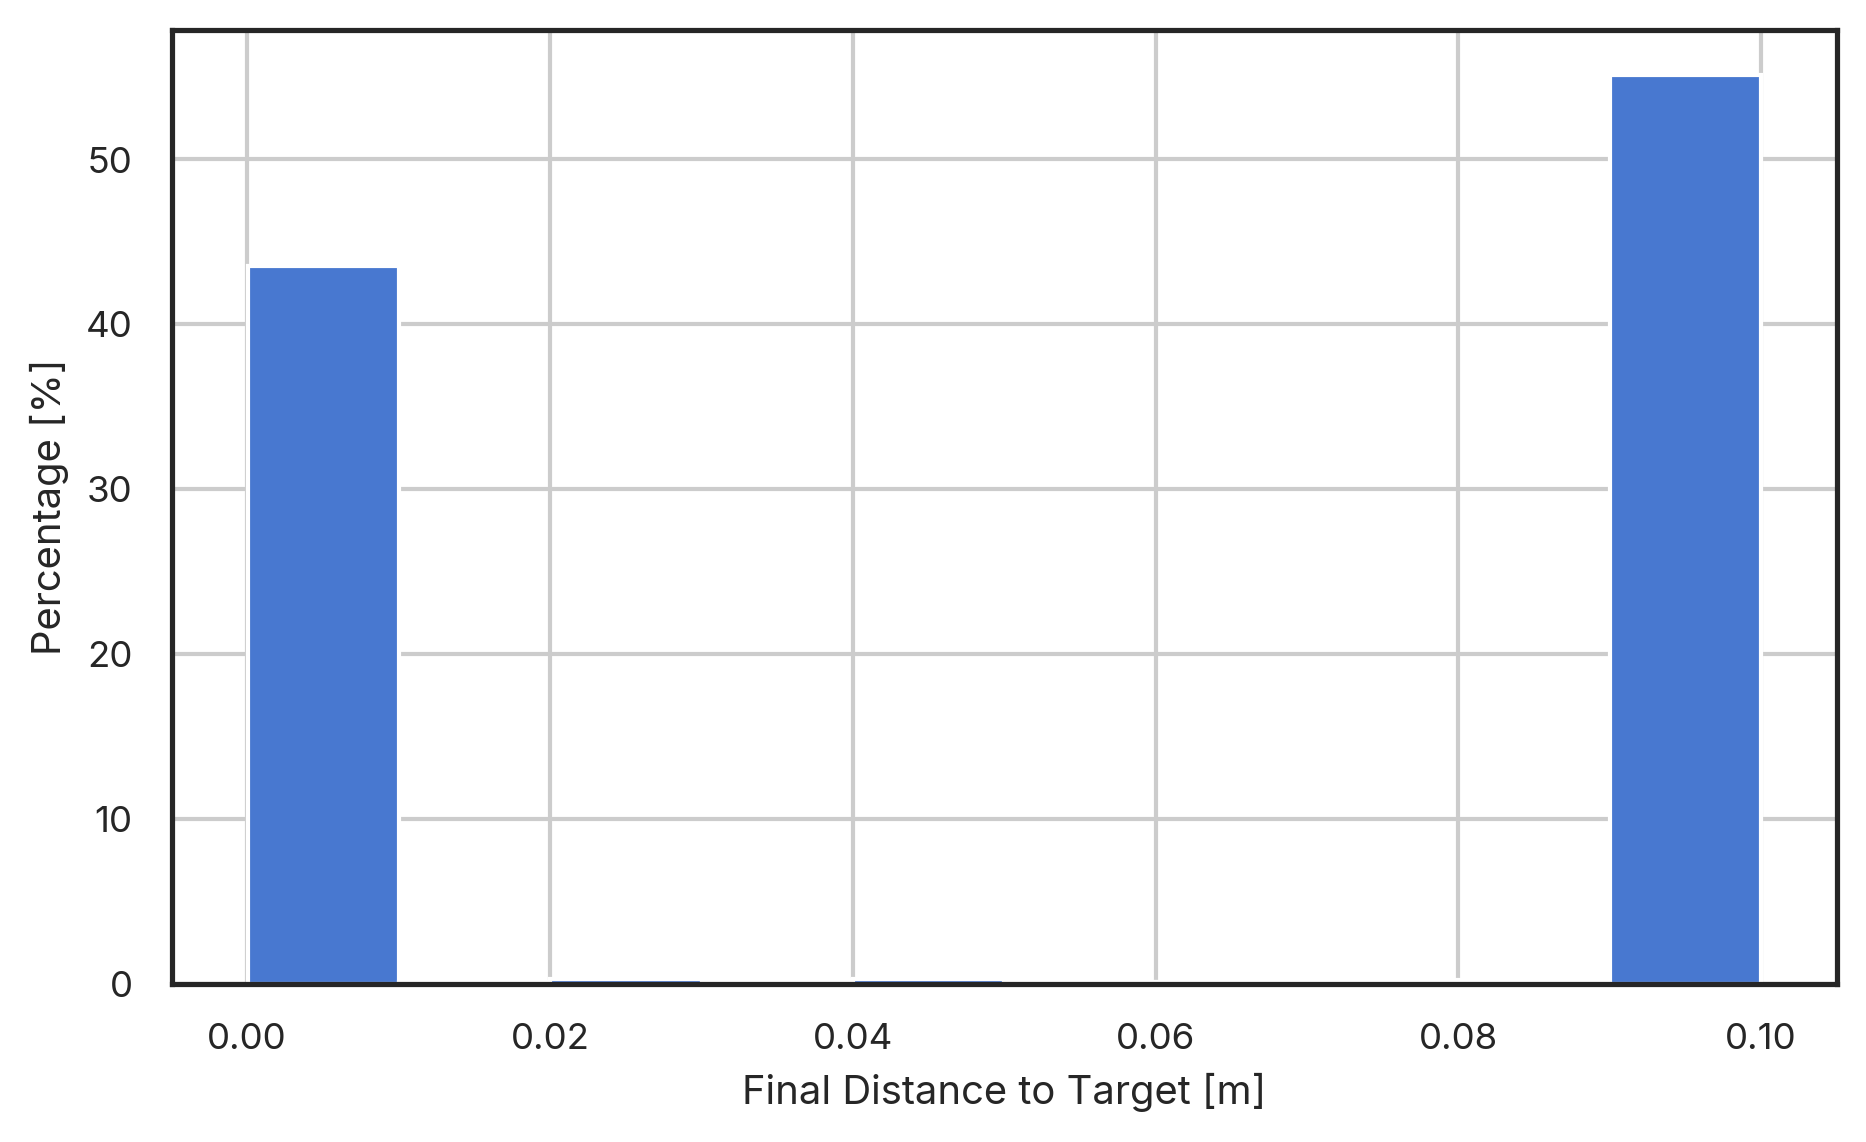

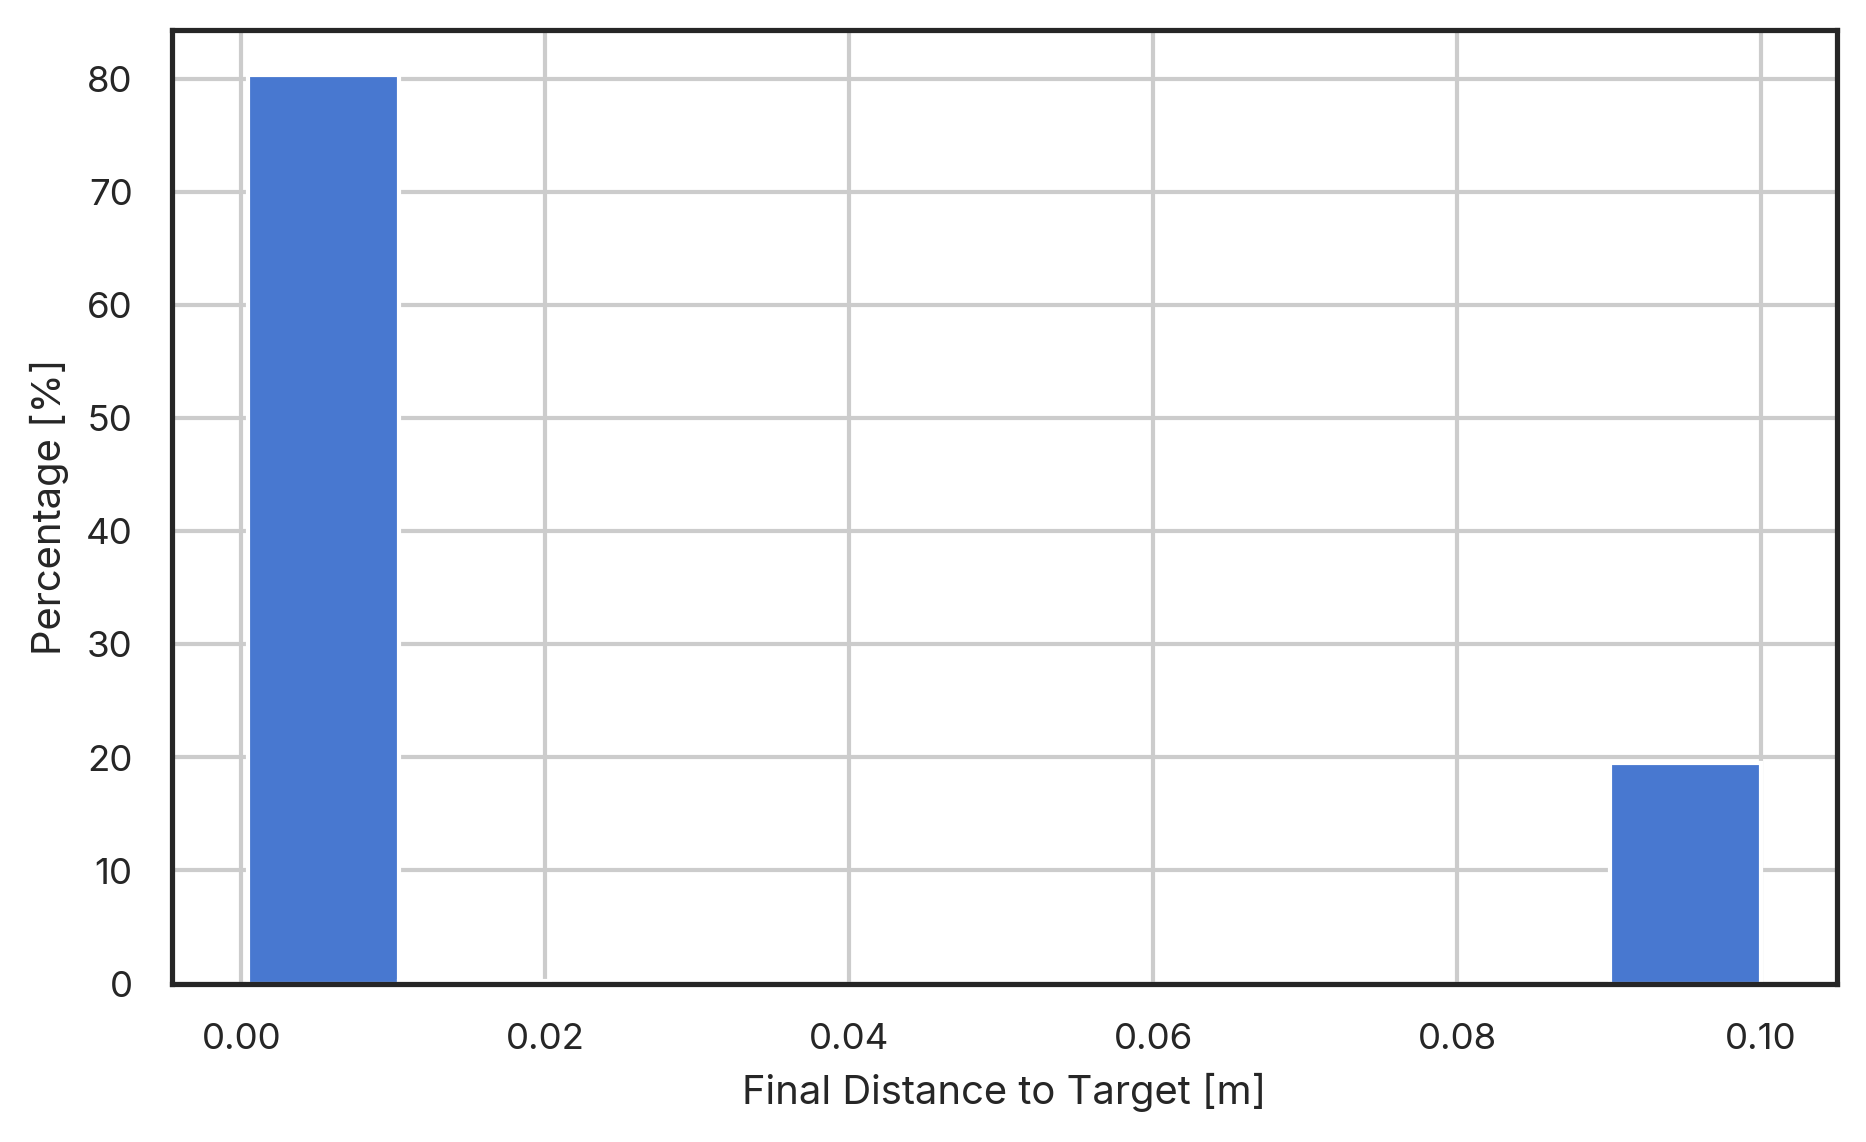

In [47]:
def final_dist_hist(exp):
    final_distance = np.linalg.norm(
    exp.payload_pos[-1, :, :] - np.array([0.0, 0.0, 1.5]),
    axis=1
    )
   

    if hasattr(exp, 'failed_runs'):
        final_distance[exp.failed_runs] = 10

    # clip at 2.5 m
    final_distance = np.clip(final_distance, 0, 0.1)

    # compute weights for percentage histogram
    weights = np.ones_like(final_distance) / final_distance.size * 100

    plt.figure(figsize=(textwidth, textwidth * 0.618))
    plt.hist(final_distance, bins=10, weights=weights)
    plt.xlabel('Final Distance to Target [m]')
    plt.ylabel('Percentage [%]')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('final_distance_histogram_percentage.pdf', bbox_inches='tight', dpi=300)

    # print success rate
    success_rate = 100 * (final_distance < 0.01).mean()
    print(f"Success rate: {success_rate:.2f}%")
    # all bins as table
    bin_counts, bin_edges = np.histogram(final_distance, bins=10)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_percentages = bin_counts / final_distance.size * 100    
    print("Final Distance Histogram (Percentage):")
    for center, count, percentage in zip(bin_centers, bin_counts, bin_percentages):
        print(f"{center:.2f} m: {count} runs ({percentage:.2f}%)")


    # calc static error mean
    static_error = final_distance[final_distance < 0.1].mean()
    print(f"Static Error Mean: {static_error:.4f} m")


final_dist_hist(baseline_recovery)
final_dist_hist(two_recovery_rl)


Baseline Recovery success rate: 43.50%
Our Method success rate: 79.70%


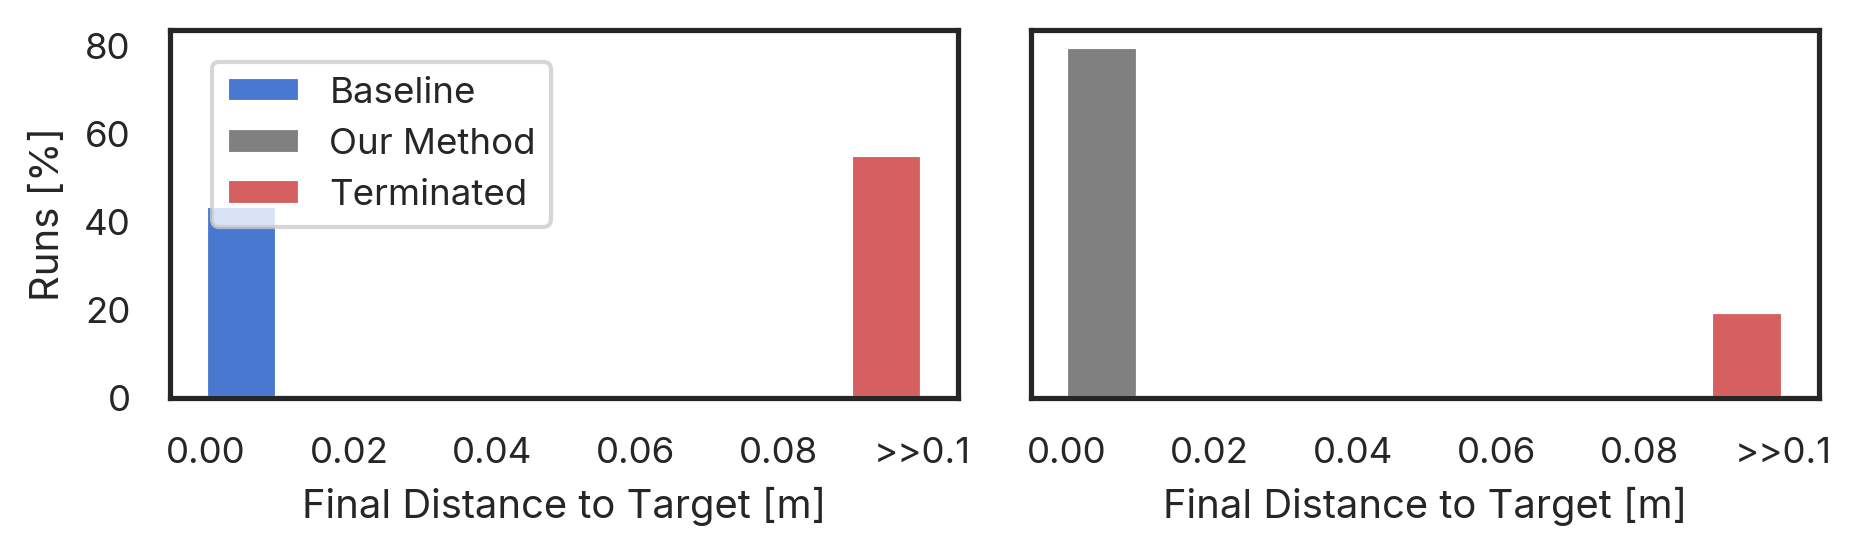

In [48]:
from matplotlib.patches import Patch

def final_dist_hist_comparison(exp_baseline, exp_ours, textwidth=textwidth):
    # define common bins
    bins = np.linspace(0, 0.1, 11)

    # two panels, side by side, share y
    fig, axes = plt.subplots(1, 2, sharey=True, sharex=True,
                             figsize=(textwidth, textwidth * 0.618 * 0.5))

    experiments = [
        (exp_baseline, 'Baseline Recovery',  'C0'),
        (exp_ours,     'Our Method',         'gray')
    ]

    # combined legend entries
    legend_handles = [
        Patch(facecolor='C0',   label='Baseline'),
        Patch(facecolor='gray', label='Our Method'),
        Patch(facecolor='C3',   label='Terminated'),
    ]

    for ax, (exp, label, color) in zip(axes, experiments):
        # compute final distances
        final_distance = np.linalg.norm(
            exp.payload_pos[-1, :, :] - np.array([0.0, 0.0, 1.5]),
            axis=1
        )
        if hasattr(exp, 'failed_runs'):
            final_distance[exp.failed_runs] = 10.0

        # clip and histogram
        final_distance = np.clip(final_distance, 0, 0.1)
        counts, _    = np.histogram(final_distance, bins=bins)
        percents     = counts / final_distance.size * 100

        # colors: default + terminated in C3
        bar_colors = [color] * (len(counts) - 1) + ['C3']

        ax.bar(bins[:-1], percents,
               width=bins[1:] - bins[:-1],
               align='edge',
               color=bar_colors)

        #ax.set_title(label)
        ax.set_ylabel('Runs [%]')
        #ax.grid()

        # console print
        success_rate = 100 * (final_distance < 0.01).mean()
        print(f"{label} success rate: {success_rate:.2f}%")

    # only show y-axis ticks/label on left plot
    axes[1].get_yaxis().set_visible(False)

    # shared x-axis tweaks on the rightmost panel
    xticks       = list(bins[:-1]) + [bins[-1]]
    xtick_labels = [f"{edge:.2f}" for edge in bins[:-1]] + ['>>0.1']
    axes[1].set_xticks(xticks[::2])
    axes[1].set_xticklabels(xtick_labels[::2])
    axes[1].set_xlabel('Final Distance to Target [m]')
    axes[0].set_xlabel('Final Distance to Target [m]')

    # single combined legend above
    fig.legend(handles=legend_handles,
               loc='upper left',
               ncol=1,
               bbox_to_anchor=(0.11, 0.9))

    plt.tight_layout()
    plt.show()
    return fig

# Usage:
hist = final_dist_hist_comparison(baseline_recovery, two_recovery_rl)
hist.savefig('out/baseline_histogram_comparison.pdf', bbox_inches='tight')

(2500, 1000)
Run 1: first hit at step (), , distance (2500,)m
Run 4: first hit at step (), , distance (2500,)m
Run 5: first hit at step (), , distance (2500,)m
Run 6: first hit at step (), , distance (2500,)m
Run 10: first hit at step (), , distance (2500,)m
Run 11: first hit at step (), , distance (2500,)m
Run 12: first hit at step (), , distance (2500,)m
Run 13: first hit at step (), , distance (2500,)m
Run 16: first hit at step (), , distance (2500,)m
Run 18: first hit at step (), , distance (2500,)m
Run 19: first hit at step (), , distance (2500,)m
Run 20: first hit at step (), , distance (2500,)m
Run 24: first hit at step (), , distance (2500,)m
Run 27: first hit at step (), , distance (2500,)m
Run 28: first hit at step (), , distance (2500,)m
Run 29: first hit at step (), , distance (2500,)m
Run 30: first hit at step (), , distance (2500,)m
Run 32: first hit at step (), , distance (2500,)m
Run 37: first hit at step (), , distance (2500,)m
Run 38: first hit at step (), , distance 

/var/folders/dr/wtxk_thd0qq23q13gk_ddc_80000gn/T/ipykernel_10531/1970092403.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Run')


Run 198: first hit at step (), , distance (2500,)m
Run 199: first hit at step (), , distance (2500,)m
Run 200: first hit at step (), , distance (2500,)m
Run 201: first hit at step (), , distance (2500,)m
Run 202: first hit at step (), , distance (2500,)m
Run 203: first hit at step (), , distance (2500,)m
Run 204: first hit at step (), , distance (2500,)m
Run 205: first hit at step (), , distance (2500,)m
Run 206: first hit at step (), , distance (2500,)m
Run 207: first hit at step (), , distance (2500,)m
Run 208: first hit at step (), , distance (2500,)m
Run 209: first hit at step (), , distance (2500,)m
Run 210: first hit at step (), , distance (2500,)m
Run 211: first hit at step (), , distance (2500,)m
Run 212: first hit at step (), , distance (2500,)m
Run 213: first hit at step (), , distance (2500,)m
Run 214: first hit at step (), , distance (2500,)m
Run 215: first hit at step (), , distance (2500,)m
Run 216: first hit at step (), , distance (2500,)m
Run 217: first hit at step (), 

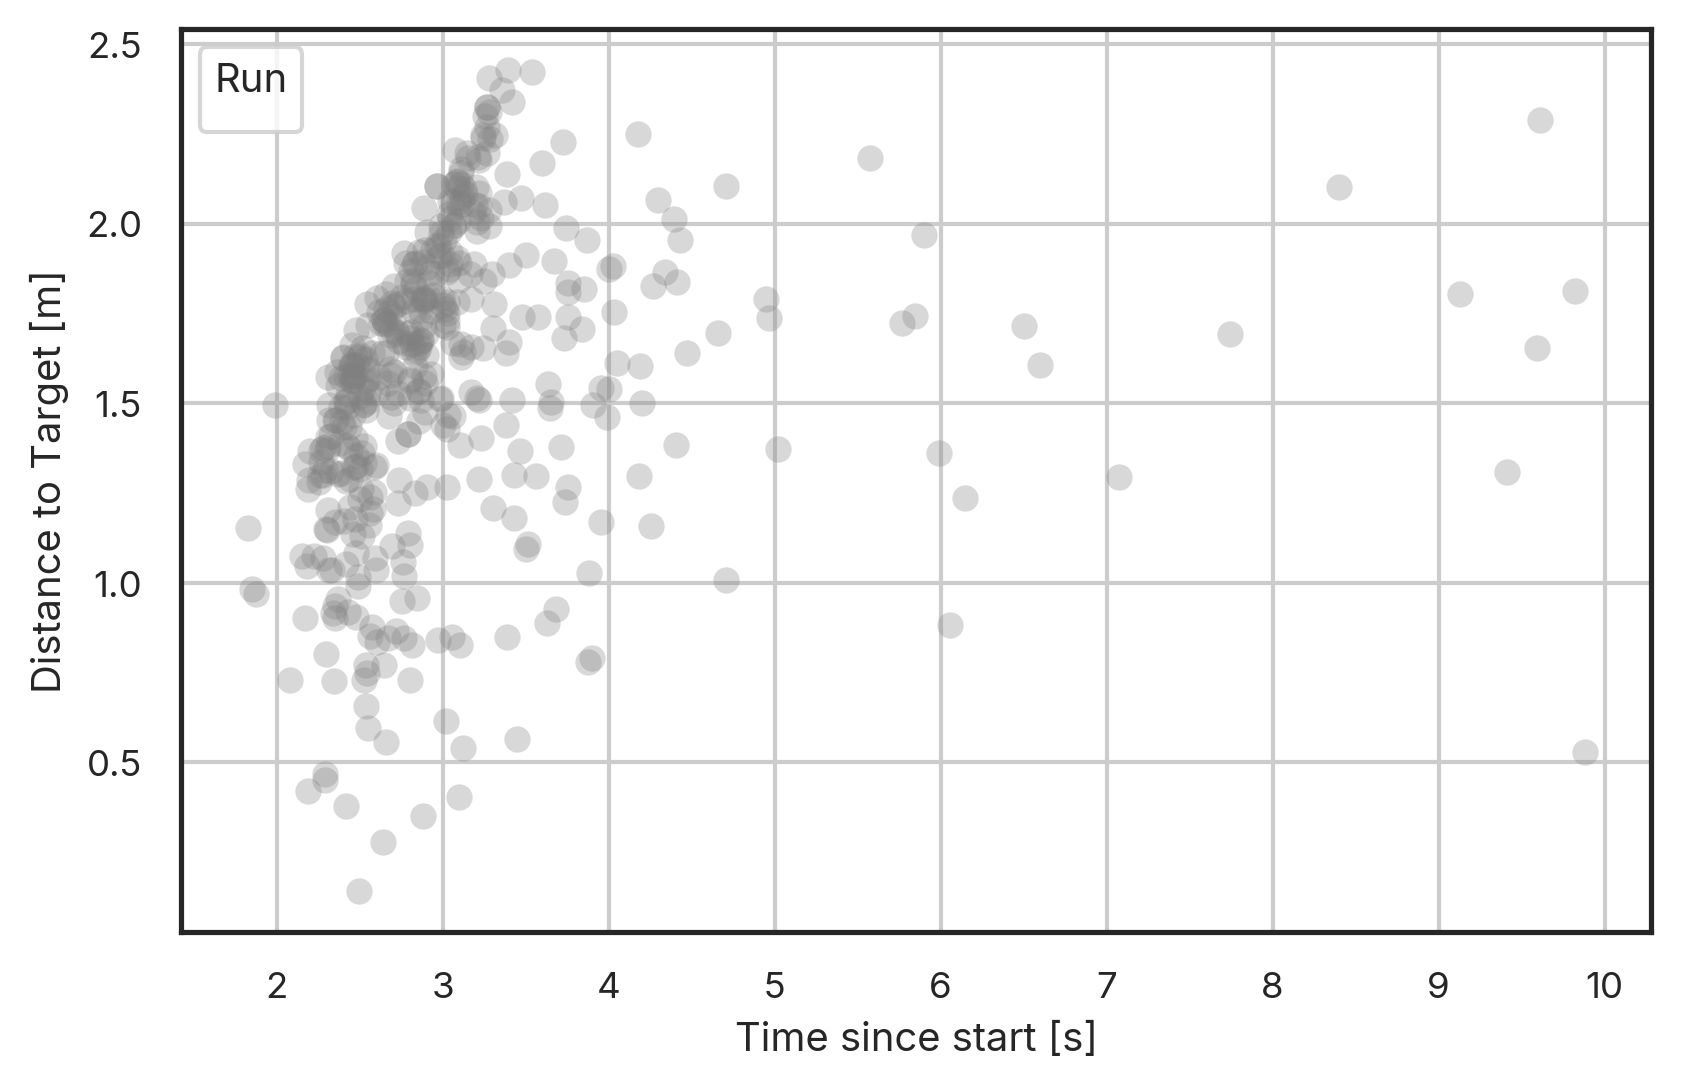

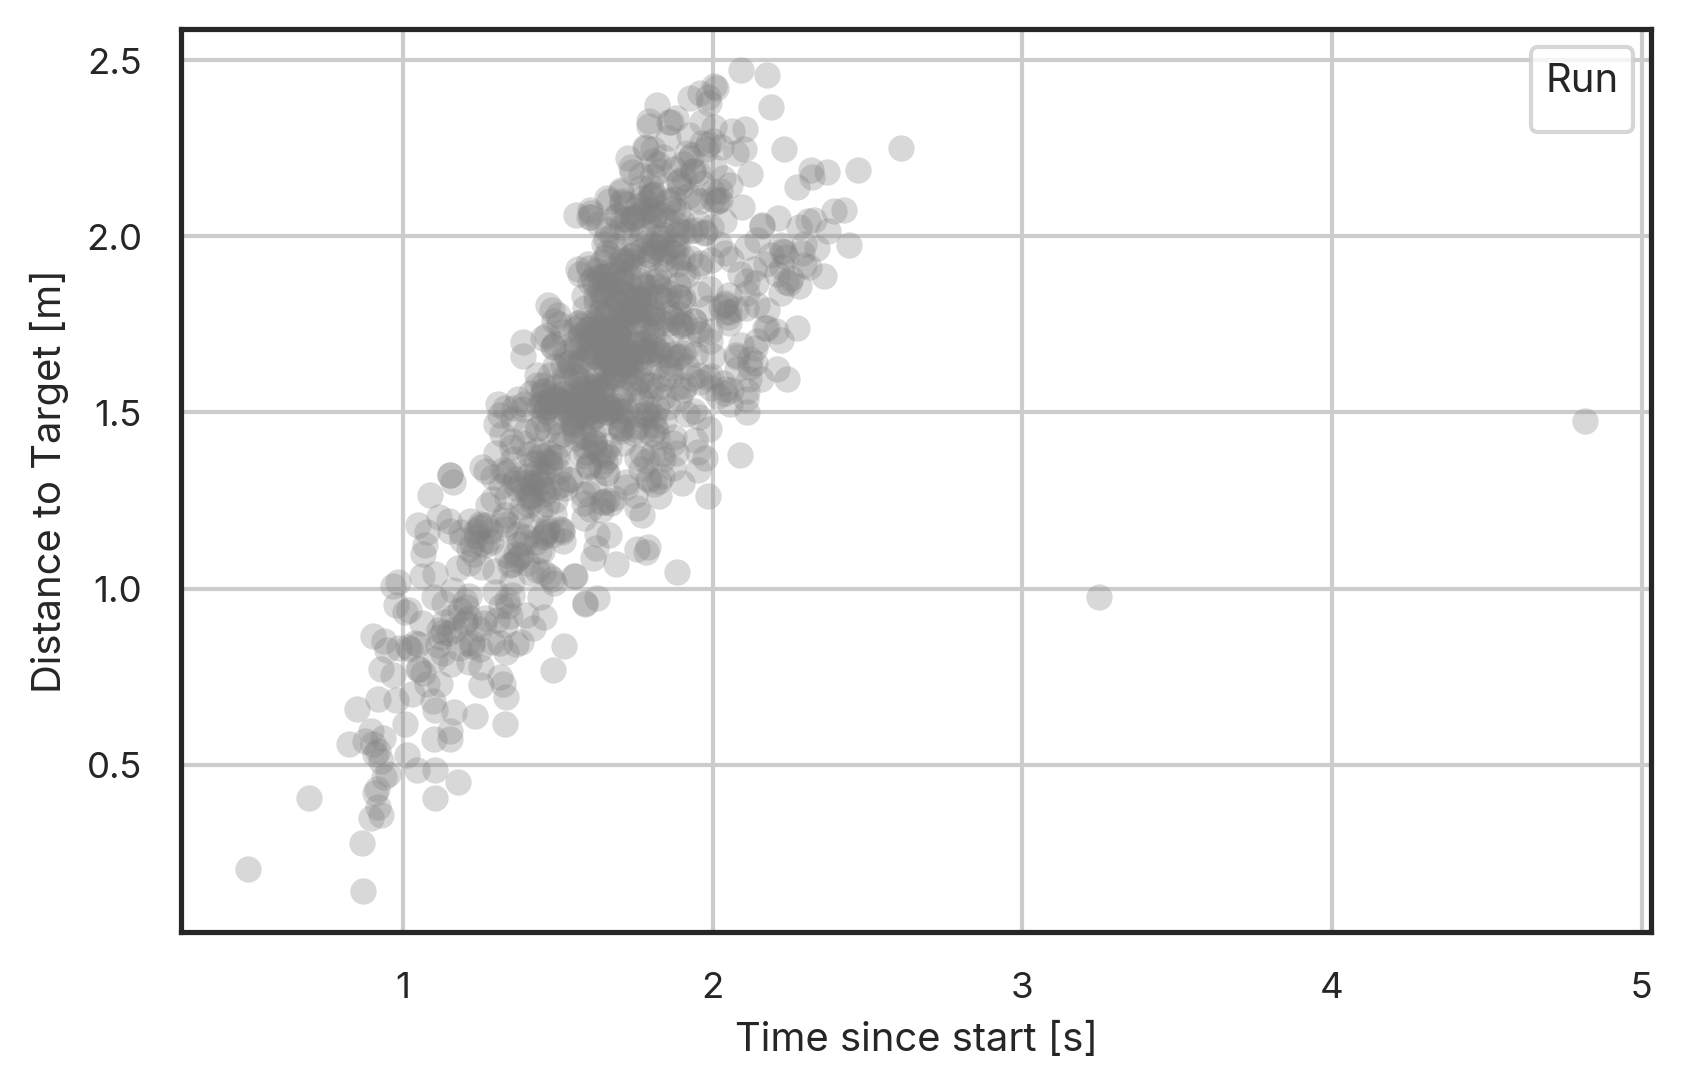

In [49]:
# plot start distance over time to reach target
def plot_start_distance_over_time(exp,
                                  runs=None,
                                  width: float = textwidth,
                                  threshold: float = 0.1):
    """
    For each run, plot the first time it reaches (and stays within) `threshold` of the target.

    Args:
        exp:        Experiment object with
                    - exp.payload_pos: shape (num_runs, num_steps, 3)
                    - exp.time:        shape (num_steps,)
        runs:       sequence of run indices to include (defaults to all).
        width:      figure width (inches)
        threshold:  distance threshold [m]
    Returns:
        fig, ax
    """
    # if time has run dimension ignore it
    time = exp.time
    if time.ndim == 2:
        time = time[:, 0]




    # choose which runs
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs[runs] if runs is not None else all_runs

    # prep figure
    fig, ax = plt.subplots(figsize=(width, width * 0.618))

    # compute distances [num_steps x num_runs]
    target_pos = np.array([0.0, 0.0, 1.5])
    distances = np.linalg.norm(exp.payload_pos - target_pos, axis=2)

    print(distances.shape)  # should be (num_steps, num_runs)

    for run in run_idxs:
        d = distances[:,run]            # shape (num_steps,)
        below = d < threshold         # bool mask
        # suffix_all[i] is True only if d[i:] is all below threshold
        suffix_all = np.logical_and.accumulate(below[::-1])[::-1]
        hits = np.where(suffix_all)[0] 

        if hits.size == 0:
            # this run never settles below threshold
            continue
       

        idx_first = hits[0]
        t_first = time[idx_first] - time[0]  # time since start
        #print shapoes
        print(f"Run {run}: first hit at step {t_first.shape}, , distance {d.shape}m")
        ax.scatter(t_first, d[0],
                   s=40, color='gray', alpha=0.3, linewidths=0)

    ax.set_xlabel('Time since start [s]')
    ax.set_ylabel(f'Distance to Target [m]')
    ax.legend(title='Run')
    ax.grid(True)
    return fig, ax

fig = plot_start_distance_over_time(baseline_recovery)
fig = plot_start_distance_over_time(two_recovery_rl)

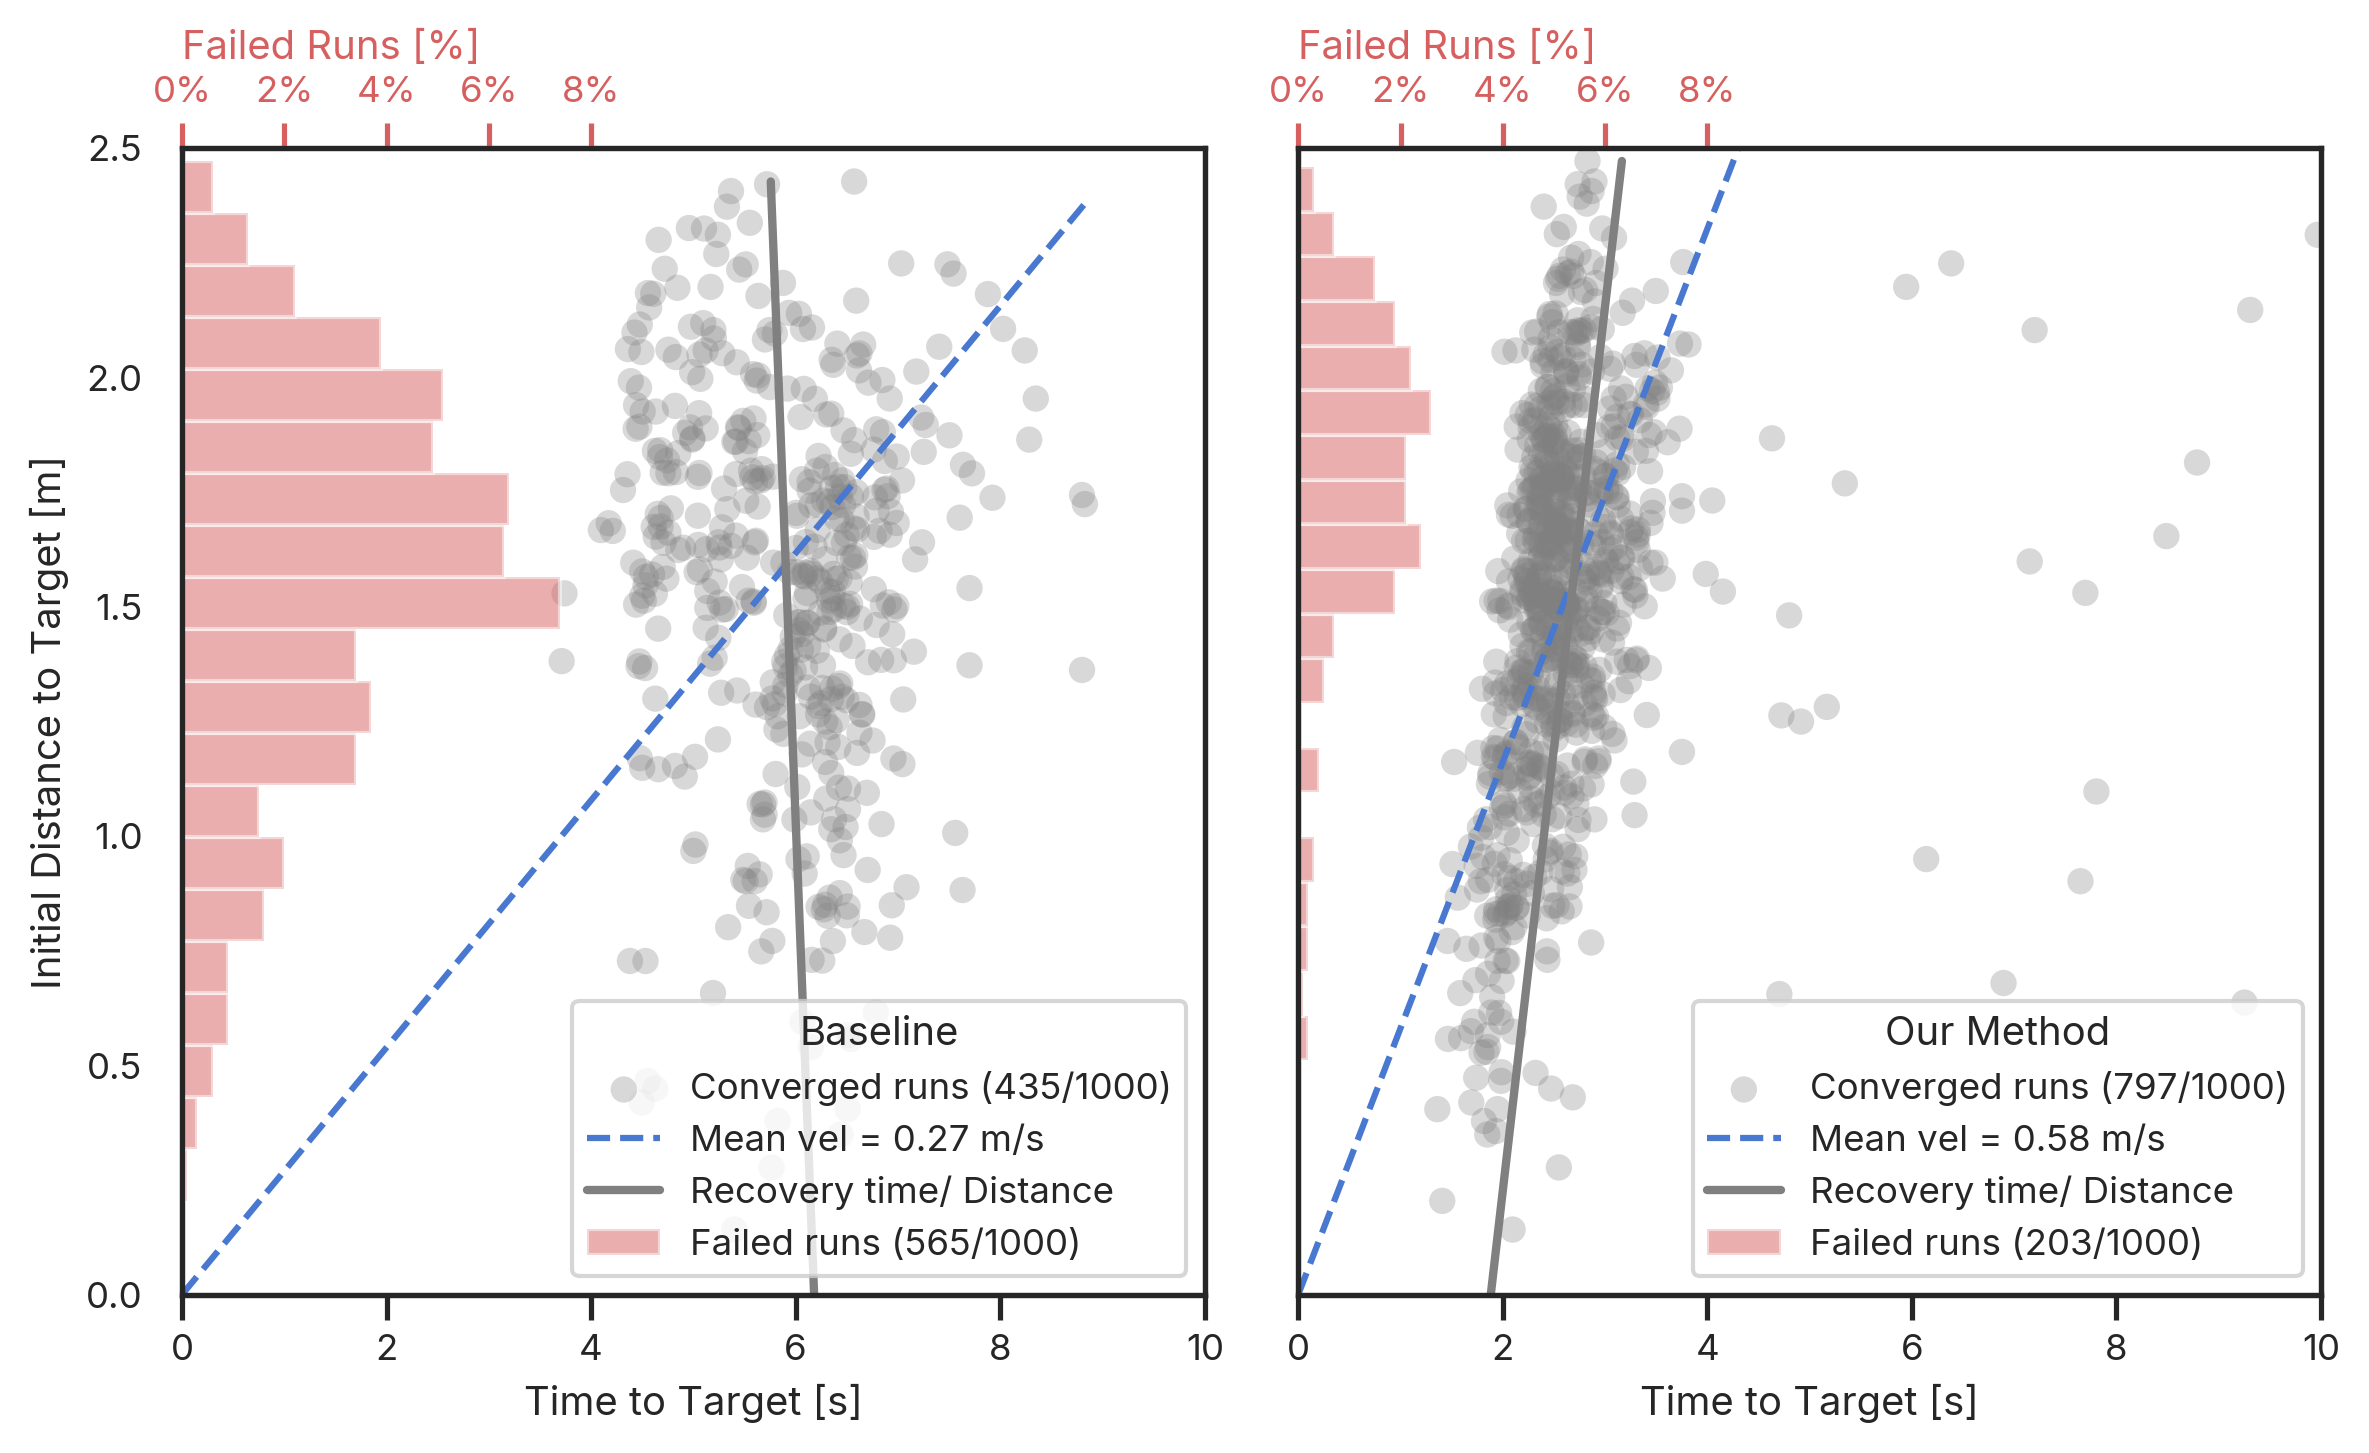

In [129]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_velocity_comparison(exps, labels=None, runs=None,
                             width: float = None,
                             threshold: float = 0.01,
                             hist_bins: int = 20):
    """
    Create side-by-side subplots comparing runs' time-to-target with velocity lines,
    and show failed runs as a histogram of initial distances with a secondary x-axis for percentages.

    Args:
        exps:      list of Experiment objects
        labels:    list of str labels for each experiment (defaults to indices)
        runs:      sequence of run indices to include (None = all)
        width:     width for each subplot in inches (None uses default figsize scaling)
        threshold: distance threshold (meters)
        hist_bins: number of bins for the failed-run distance histogram
    Returns:
        fig, axes
    """
    n = len(exps)
    if labels is None:
        labels = [f"Exp {i}" for i in range(n)]

    # figure setup
    figsize = (width or n * 4, (width or n * 4) * 0.618)
    fig, axes = plt.subplots(1, n, sharey=True, figsize=figsize)
    if n == 1:
        axes = [axes]

    for ax, exp, label in zip(axes, exps, labels):
        # time vector
        time = exp.time
        if time.ndim == 2:
            time = time[:, 0]

        # run selection
        all_runs = np.arange(exp.num_runs)
        run_idxs = all_runs[runs] if runs is not None else all_runs

        # distances over time
        target = np.array([0.0, 0.0, 1.5])
        distances = np.linalg.norm(exp.payload_pos - target, axis=2)

        # gather stats
        t_hits = []
        d_initial = []
        failed_runs = []

        for run in run_idxs:
            d = distances[:, run]
            below = d < threshold
            settled = np.logical_and.accumulate(below[::-1])[::-1]
            hits = np.where(settled)[0]
            if hits.size == 0 or (hasattr(exp, 'failed_runs') and run in exp.failed_runs):
                failed_runs.append(run)
            else:
                first = hits[0]
                t0 = time[first] - time[0]
                t_hits.append(t0)
                d_initial.append(d[0])

        # counts for legend
        total_runs = len(run_idxs)
        num_converged = len(t_hits)
        num_failed = len(failed_runs)

        # plot converged runs once
        if num_converged > 0:
            sc = ax.scatter(t_hits, d_initial, s=40,
                            color='gray', alpha=0.3,
                            edgecolors='none')
            sc.set_label(f"Converged runs ({num_converged}/{total_runs})")

            # velocity lines
            velocities = np.array(d_initial) / np.array(t_hits)
            avg_vel = velocities.mean()
            x_max = np.max(t_hits)
            x_line = np.array([0.0, x_max])
            ax.plot(x_line, avg_vel * x_line, '--',
                    label=f"Mean vel = {avg_vel:.2f} m/s")
            

            #    t = m * d + b
            slope, intercept = np.polyfit(d_initial, t_hits, 1)
            d_line = np.array([0.0, max(d_initial)])
            t_line = slope * d_line + intercept
            ax.plot(t_line, d_line, color='gray', linewidth=2,
                    label=f"Recovery time/ Distance")

        # histogram of failed-run distances
        ax_hist = None
        if num_failed > 0:
            d_fail = distances[0, failed_runs]
            ax_hist = ax.twiny()
            hist_vals, bins = np.histogram(d_fail, bins=hist_bins)
            hist_perc = hist_vals / total_runs * 100
            bin_centers = (bins[:-1] + bins[1:]) / 2
            heights = bins[1] - bins[0]
            bars = ax_hist.barh(bin_centers, hist_perc,
                                 height=heights,
                                 alpha=0.5,
                                 color='C3')
            bars[0].set_label(f"Failed runs ({num_failed}/{total_runs})")

            ax_hist.set_xlabel('Failed Runs [%]', color='C3', loc='left')
            ax_hist.xaxis.set_major_formatter(
                plt.FuncFormatter(lambda x, _: f"{int(x)}%"))
            ax_hist.set_xticks(np.arange(0, 9, 2))
            ax_hist.tick_params(axis='x', colors='C3')
            ax_hist.set_ylim(ax.get_ylim())
            ax_hist.set_xlim(0, 20)

        # legend combining both axes
        handles, labels = [], []
        h1, l1 = ax.get_legend_handles_labels()
        handles.extend(h1)
        labels.extend(l1)
        if ax_hist is not None:
            h2, l2 = ax_hist.get_legend_handles_labels()
            handles.extend(h2)
            labels.extend(l2)
        ax.legend(handles, labels, loc='lower right', title=label)

        # labels and grid
        ax.set_xlabel('Time to Target [s]')

    # common y label and limits
    axes[0].set_ylabel('Initial Distance to Target [m]')
    for ax in axes:
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 2.5)
       

    fig.tight_layout()
    return fig, axes




fig, axes = plot_velocity_comparison(
    exps=[baseline_recovery, two_recovery_rl],
    labels=['Baseline', 'Our Method'],
    runs=None,         # or specify a list like [0,1,2,…]
    threshold=0.01
)

fig.savefig('out/baseline_stat_comparison.pdf', bbox_inches='tight')

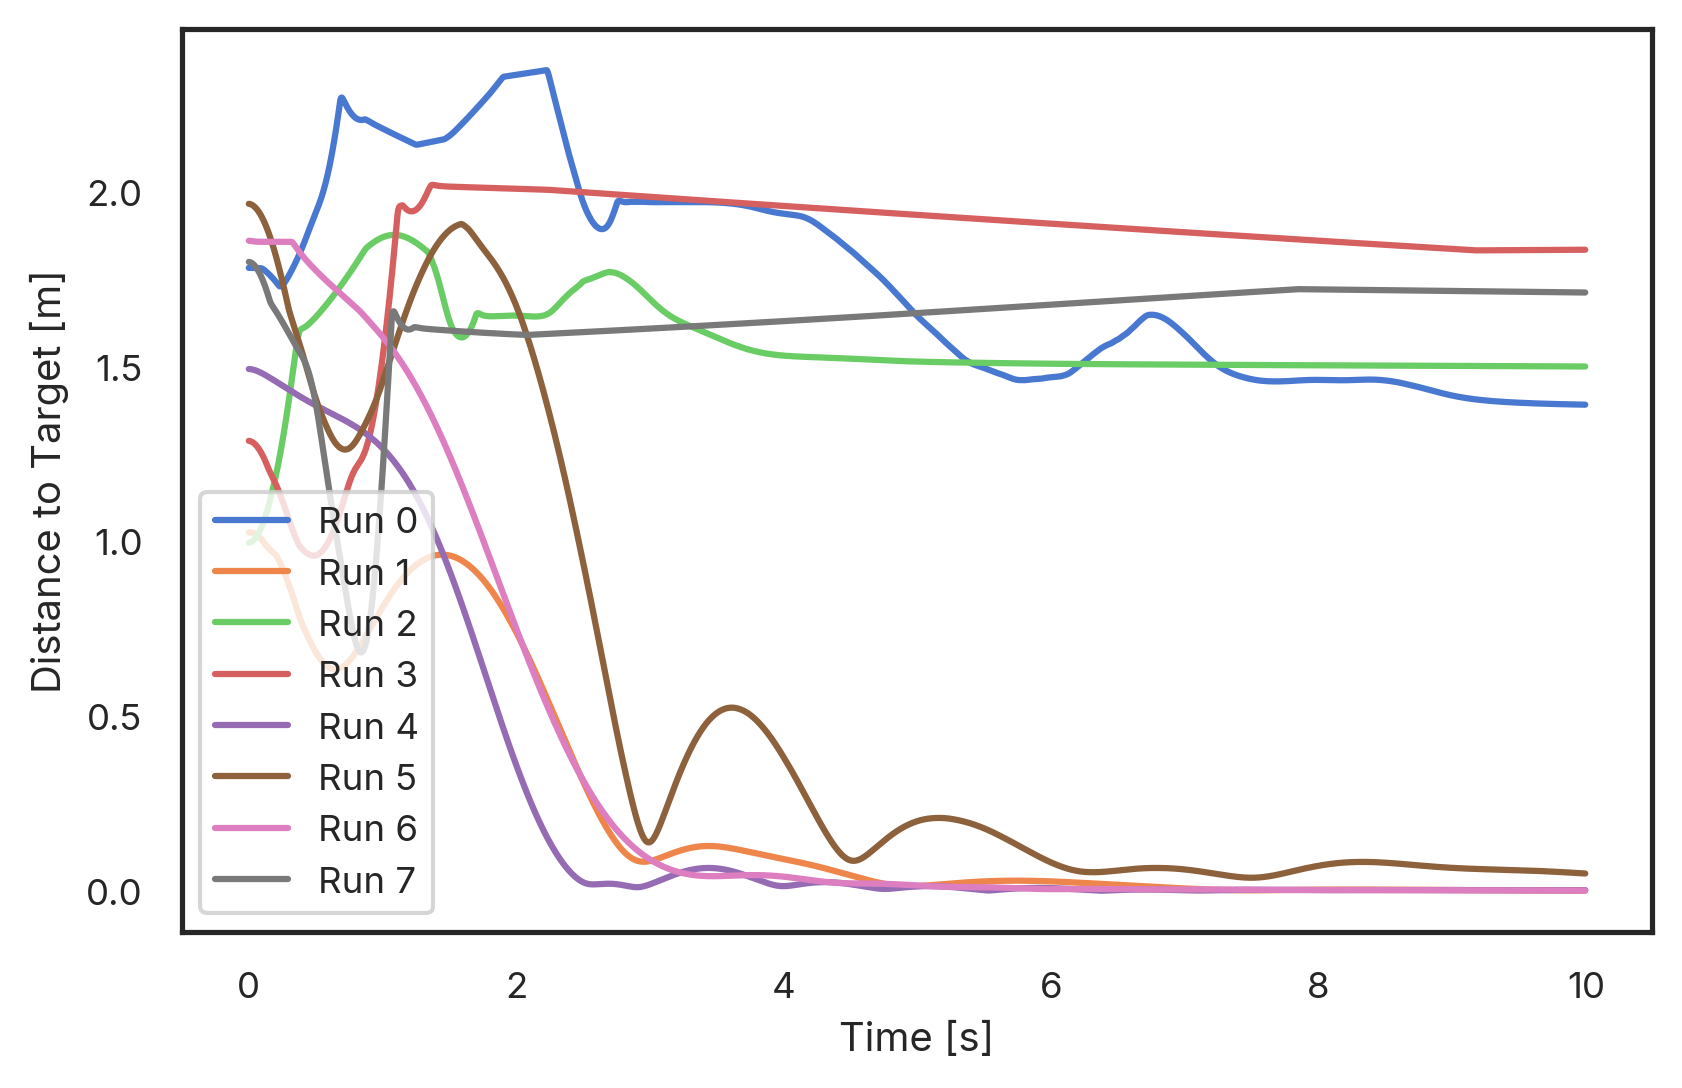

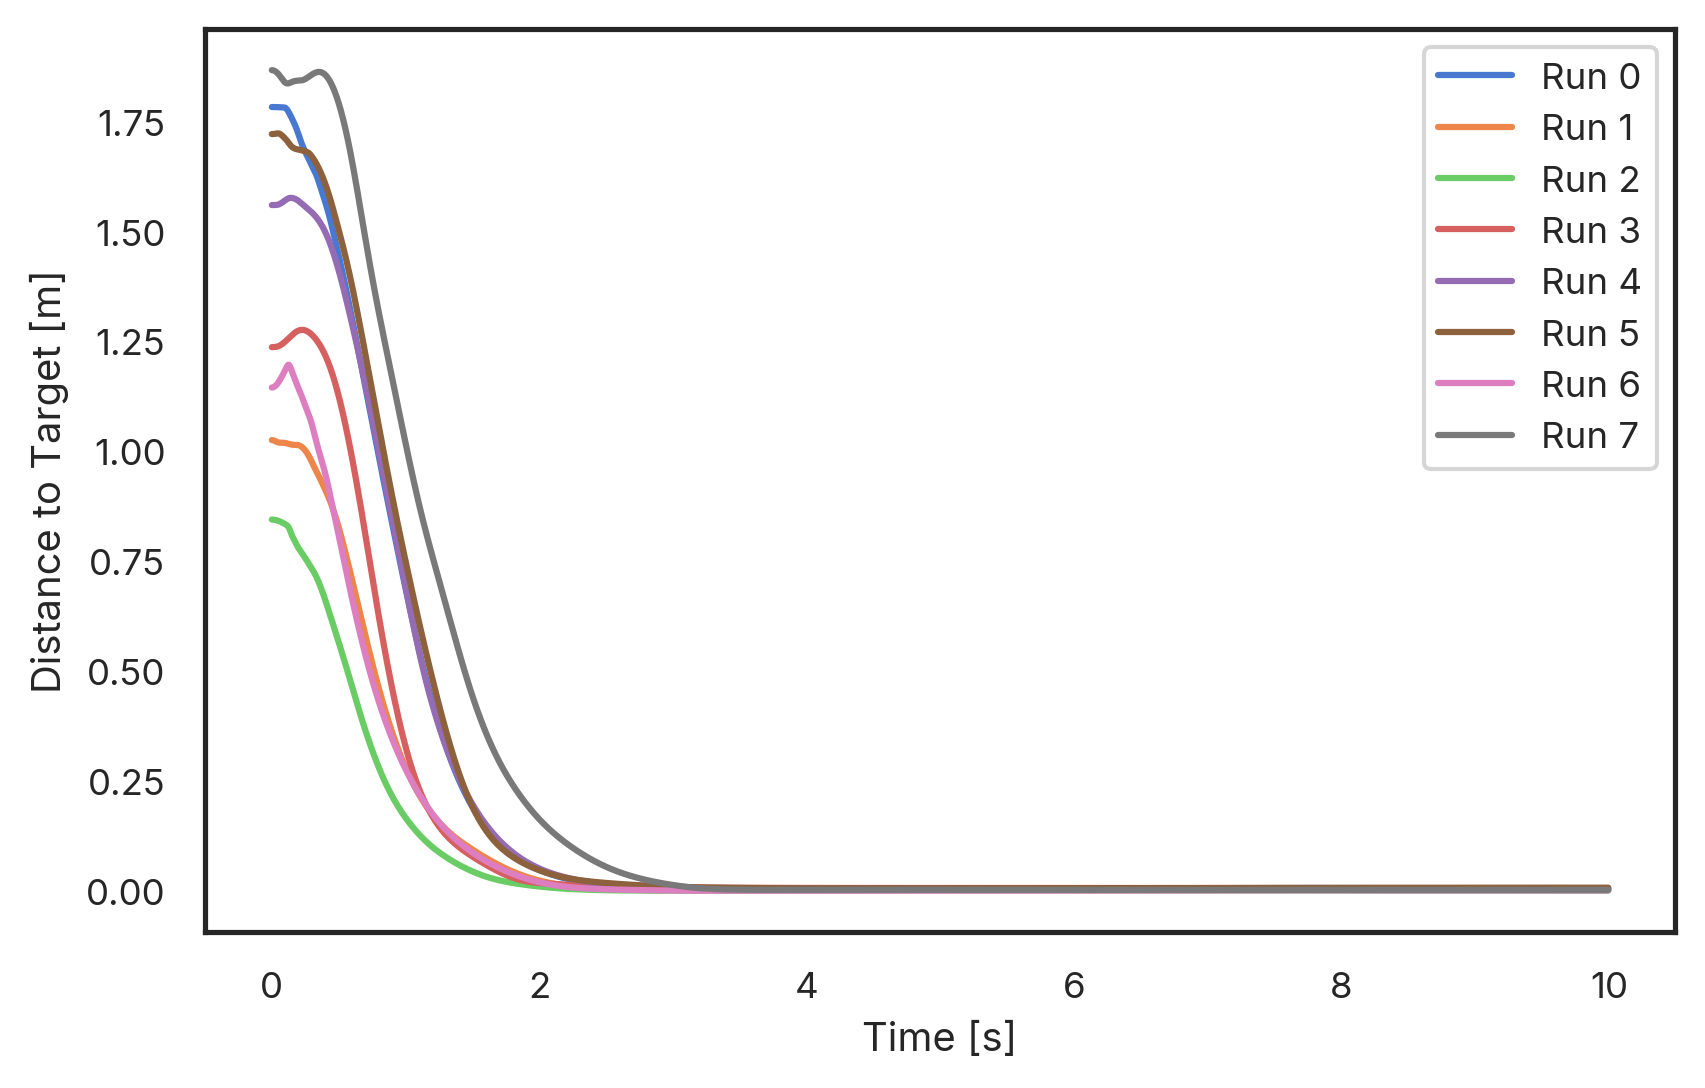

In [128]:
# plot distance over time for the first 10 runs
def plot_distance_over_time(exp, runs=None, width: float = textwidth):

    distance = np.linalg.norm(
        exp.payload_pos - np.array([0.0, 0.0, 1.5]),
        axis=2
    )

    
    # choose runs
    all_runs = np.arange(exp.num_runs)

    if runs is None:
        run_idxs = all_runs
    else:
        # build a lookup from value → its first index
        idx_map = { val: idx for idx, val in enumerate(runs) }

        # for each run number, pull out the index (or -1 if missing)
        mapped_ids = np.array([ idx_map.get(r, -1) for r in runs ])

        run_idxs = mapped_ids

    

    time = exp.time
    if time.ndim == 2:
        time = time[:, 0]

    # prep figure
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for run in run_idxs:
        ax.plot(time, distance[:, run], label=f"Run {run}")
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Distance to Target [m]")
    ax.legend()
    return fig, ax
fig, ax = plot_distance_over_time(baseline_recovery, runs=[376, 387, 302, 382,259, 58, 290, 562])
fig, ax = plot_distance_over_time(two_recovery_rl, runs=[376, 387, 302, 382,259, 58, 290, 562])


(2500, 1000, 3)


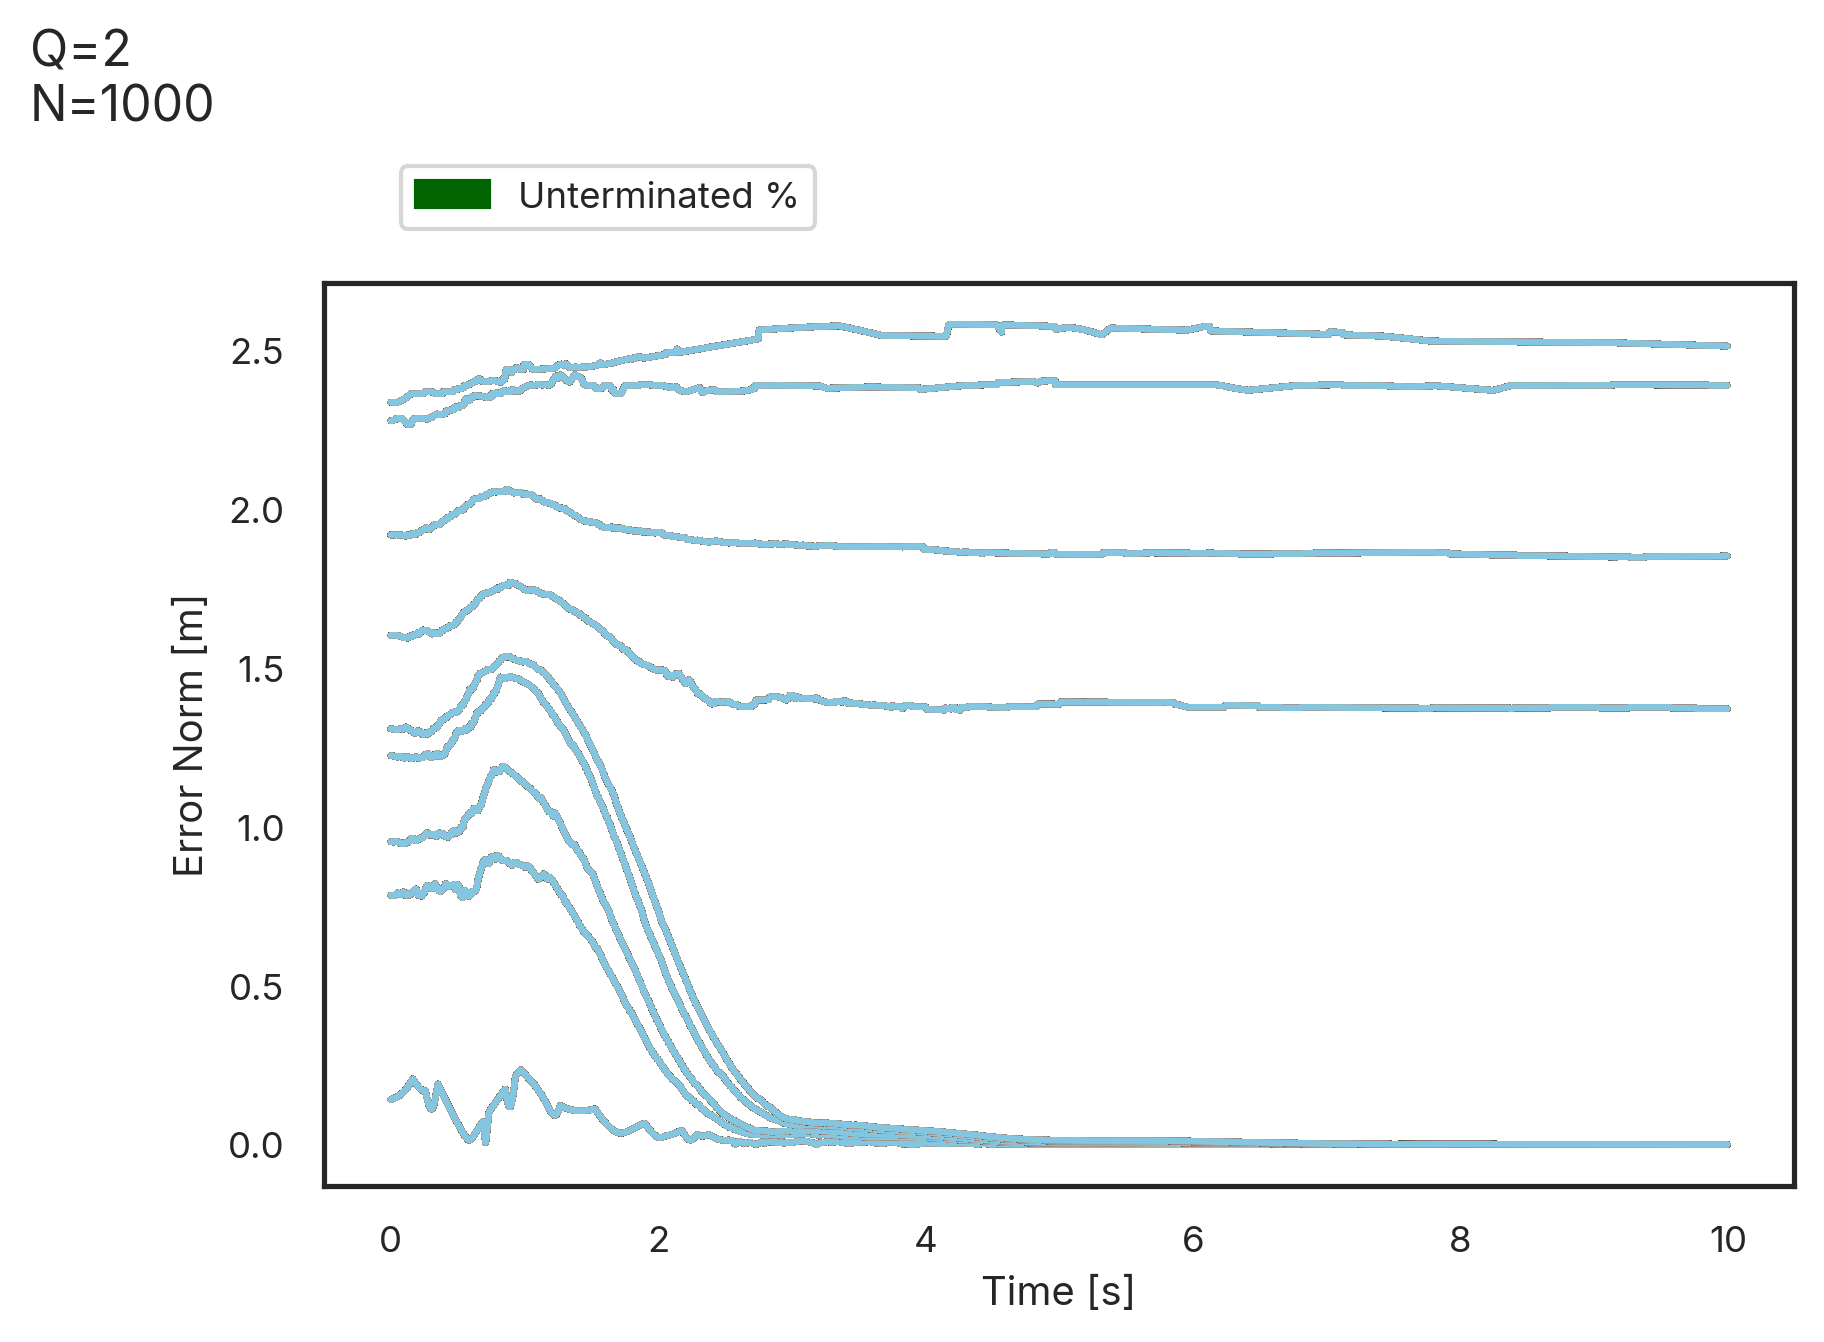

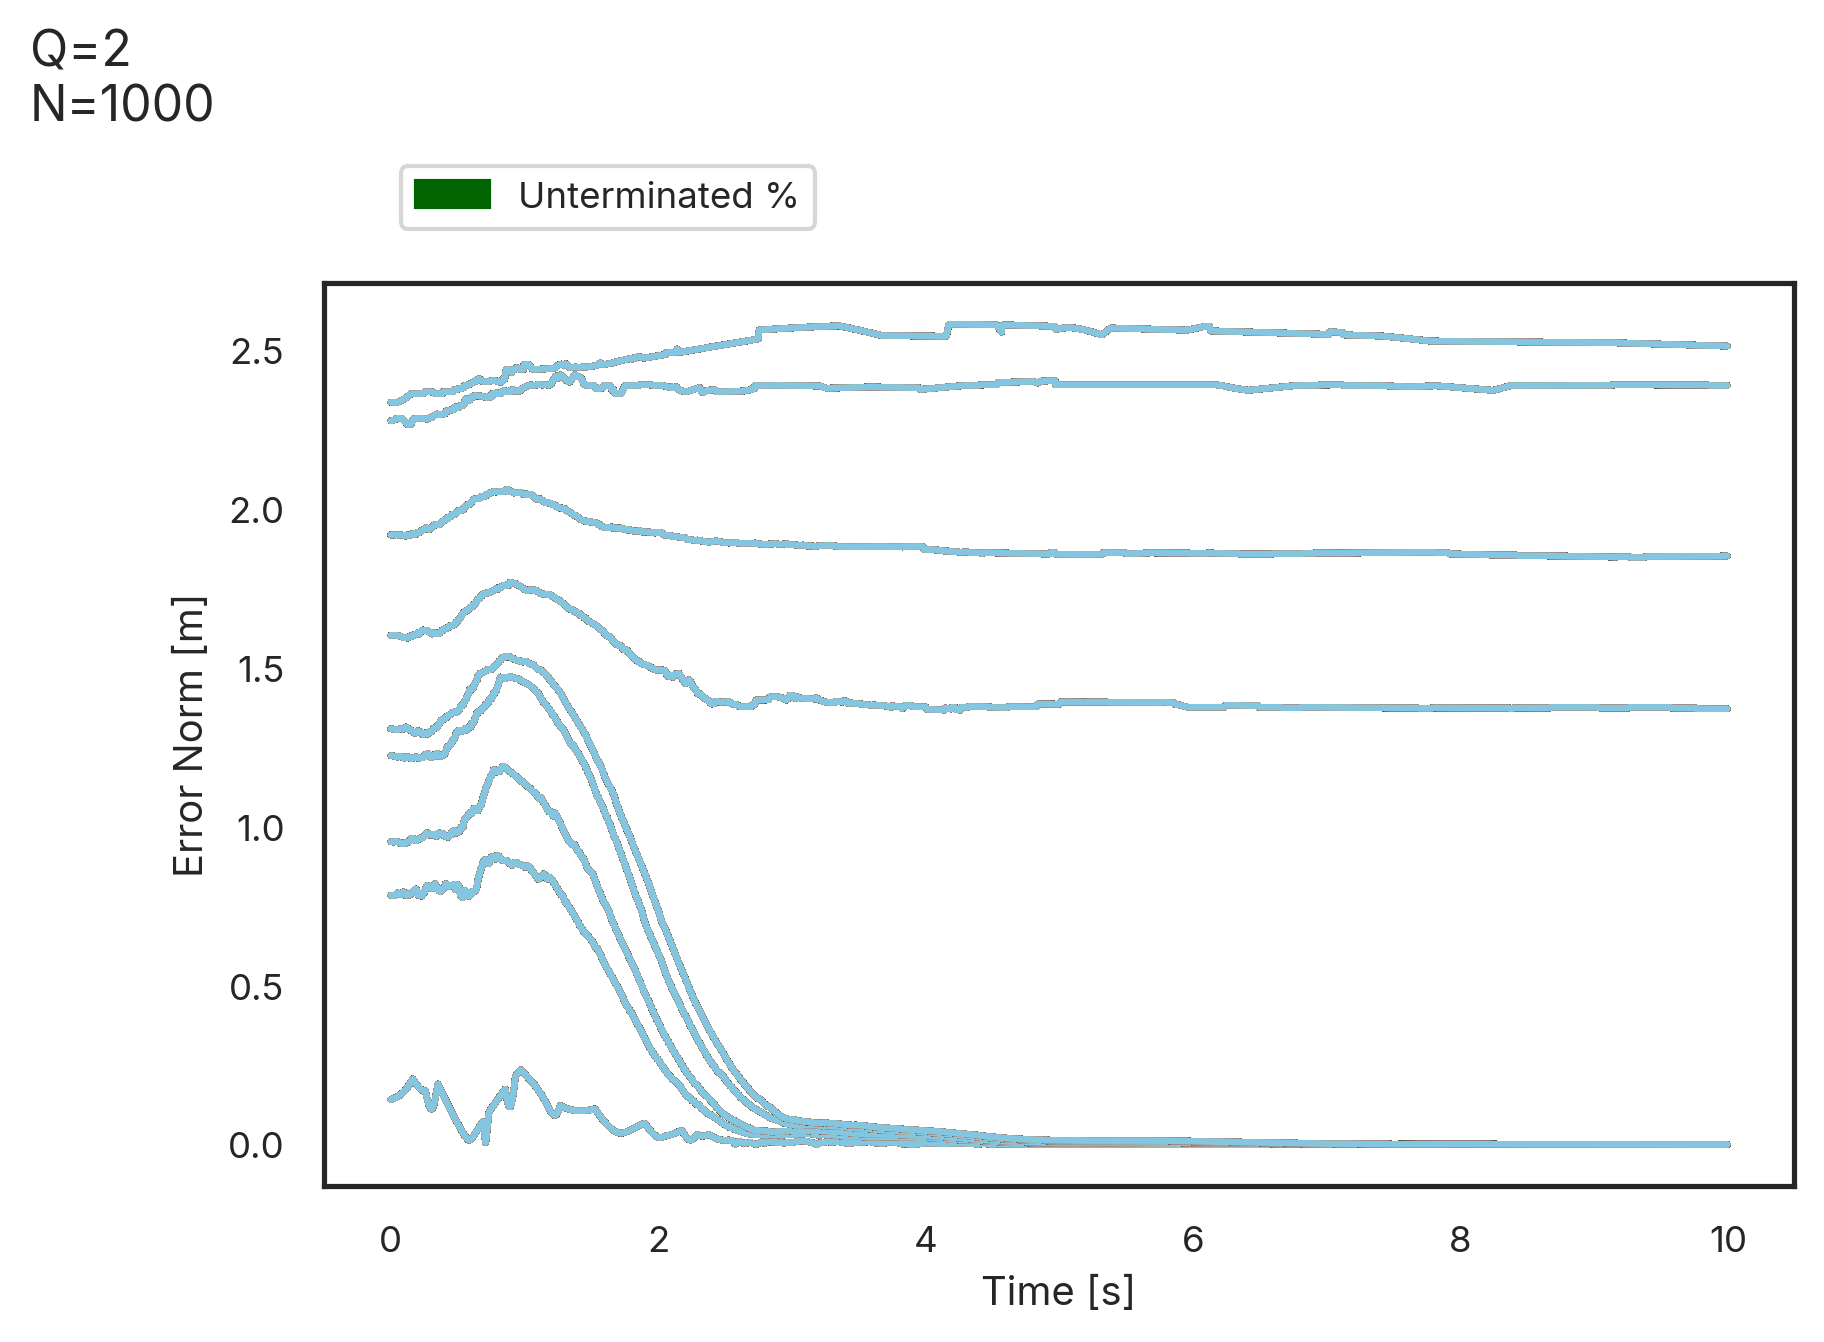

In [51]:
import matplotlib.patches as mpatches
def plot_error_percentiles(exp: Experiment, runs=None, width: float = textwidth):
    """
    Show error-norm percentiles and a histogram of termination times (as %),
    and highlight the last bin as “Unterminated runs”.
    """
    # --- select runs and compute norms ---
    all_runs = np.arange(exp.num_runs)
    run_idxs = all_runs if runs is None else all_runs[runs]

    max_t = exp.payload_pos.shape[0]
    print(exp.payload_pos.shape)
    norms = np.linalg.norm(exp.payload_pos[:max_t, :, :]-np.array([0.0, 0.0, 1.5]), axis=-1)

    # --- set up figure & primary axis (percentiles) ---
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in [0, 5, 10, 20 ,25, 50, 80, 98, 99]:
        ax.plot(
            exp.time[:max_t],
            np.percentile(norms, p, axis=1),
            #label=f'{p}th Percentile',
        )
    ax.set(
        xlabel='Time [s]',
        ylabel='Error Norm [m]',
    )

    # # --- compute termination histogram as percentages ---
    # hist, bins = np.histogram(exp.first_dones[run_idxs] * exp.dt, bins=20)
    # freq_pct = hist / hist.sum() * 100  # convert to percent
    # # set lower y limit to 0
    # ax.set_ylim(bottom=0)

    # # --- plot bars on the secondary axis ---
    # ax2 = ax.twinx()
    # bars = ax2.bar(
    #     bins[:-1],
    #     freq_pct,
    #     width=np.diff(bins),
    #     alpha=0.5,
    #     color='gray',
    #     align='edge',
    #     label='Termination %'
    # )
    # ax2.set_ylim(0, 100)
    # #ax2.set_ylabel('Termination %')
    # pct_ticks = np.linspace(0, 100, 5)
    # ax2.set_yticks(pct_ticks)
    # ax2.set_yticklabels([f'{int(t)}%' for t in pct_ticks])

    # # --- highlight the last bar as "Unterminated runs" ---
    # last_bar = bars[-1]
    # last_bar.set_color('darkgreen')
    # last_bar.set_alpha(0.8)

    # --- combine legends from both axes + highlight patch ---
    h1, l1 = ax.get_legend_handles_labels()
    # h2, l2 = ax2.get_legend_handles_labels()
    highlight_patch = mpatches.Patch(color='darkgreen', label='Unterminated')
    ax.legend(
        handles=h1 + [highlight_patch],
        labels=l1  + ['Unterminated %'],
        loc ='lower left',
        ncol=2,
        bbox_to_anchor=(0.04, 1.04)
    )
    fig.text(-0.03, 1.01, f'Q={exp.num_quads}\nN={len(run_idxs)}', fontsize=12, ha='left', va='bottom',)

    return fig

plot_error_percentiles(baseline_recovery)
